# Importing Necessary Libraries

In [1]:
%matplotlib notebook

import math
import time
from collections import deque

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


# Load up the data
## Google stock prices dataset
<br>Data from [Yahoo Finance](https://finance.yahoo.com/) and it contains **AMD** and **GOOGLE** daily historical price, starting from 2009 to 2018.
<br>You can find the data [here](https://www.kaggle.com/gunhee/amdgoogle)

In [2]:
google_df = pd.read_csv("GOOGLE.csv")
google_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700
1,2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700
2,2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500
3,2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200
4,2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100


In [3]:
google_df = google_df[['Date','Close']]
google_df.head()

,Date,Close
0,2009-05-22,196.946945
1,2009-05-26,202.382385
2,2009-05-27,202.982986
3,2009-05-28,205.405411
4,2009-05-29,208.823822


Drop the date column.

In [4]:
google_df.drop(['Date'], axis=1, inplace=True)
google_df.head()

,Close
0,196.946945
1,202.382385
2,202.982986
3,205.405411
4,208.823822


In [5]:
google_df.rename(columns={'Close':'Price'}, inplace=True)
google_df.head()

,Price
0,196.946945
1,202.382385
2,202.982986
3,205.405411
4,208.823822


Drop Nan values.

In [6]:
print("Before dropping Nan values: ", len(google_df))

Before dropping Nan values:  2335


In [7]:
google_df.dropna(inplace=True)

In [8]:
print("After dropping Nan values: ", len(google_df))

After dropping Nan values:  2335


## Plot the data

<IPython.core.display.Javascript object>


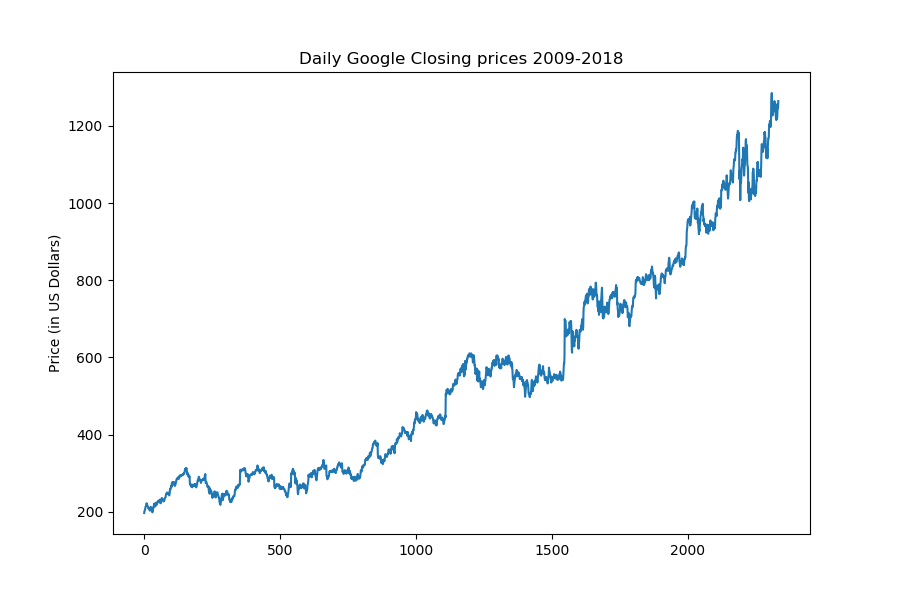

In [9]:
plt.figure(figsize=(9,6))
plt.plot(google_df.index, google_df)
plt.title("Daily Google Closing prices 2009-2018")
plt.ylabel("Price (in US Dollars)")
plt.show()

# Data Preprocessing

These functions will be used to scale, generate sequences, and split our sequential data in order to prepare it for input to an LSTM Keras model.

This function is for scaling the data.
<br>**Note:** we need to scale because if we fit the model on unscaled data that has a wide range of values, then it is possible for large inputs to slow down the learning and convergence of our network and in some cases prevent the network from effectively learning your problem.

In [16]:
def scale_data(input_3d_array):
    """
    This function transforms the values of a 3D numpy array using MinMaxScaler from sklearn.model_selection
    """
    original_shape = input_3d_array.shape
    # Reshaping the the array in order to make it 2-Dimensional array
    # since fit_transform function accepts only 2D array as an input parameter.
    input_3d_array = input_3d_array.reshape(input_3d_array.shape[0],input_3d_array.shape[1])
    # Transforming the values.
    input_3d_array = min_max_scaler.fit_transform(input_3d_array)
    # Reshaping the array back to its original shape.
    input_3d_array = input_3d_array.reshape(original_shape)
    
    return input_3d_array

This function will be used to generate input sequences which consists of (X,y) arrays, where:
<br> X : the prices of the days preceding the target day (the day that we want to predict the price for).
<br> y : the price on target day.

In [17]:
def preprocess_data(data_array, window):
    """
    This method takes a numpy array as input, and returns X,y numpy arrays as the output.
    N = len(data)
    X (data_array) = shape(N-window,window,1)
    y = shape(N-window,1)
    """
    X = []
    y = []
    SEQ_LEN = window
    # the prices of a number of squential days equal to the window parameter
    prev_days = deque(maxlen=SEQ_LEN)
    for index,item in enumerate(data_array[:-1]):
        prev_days.append(item)
        if len(prev_days) == SEQ_LEN:
            X.append(np.array(prev_days))
            y.append(data_array[index+1])
    
    return np.array(X), np.array(y)

This function will be used for splitting the data into training and testing sets.

In [18]:
def split_data_no_validation(X_main, y_main, test_size):
    """
    This function returns training and testing data based on the wanted split size. as follows:
    output: X_train, X_test, y_train, y_test (Numpy arrays)
    The arguments:
    X_main: inputs (a Numpy array)
    y_main: targets (a Numpy array)
    split_size: float ex. 0.1 means 10% for testing and 90% for training
    """
        
    X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=test_size)
    
    return X_train, X_test, y_train, y_test

# Saving some input samples to test the trained models

We are going to train **6 models** in order to experiment the different resutls and pick out what is best. Concretely, these are the characteristics that we are going to build the models on:
* Save **100** input samples from the last part of the data. **(70% training data, 30% testing data)**
* Save **100** input samples. **(50% training, 50% testing)**
* Save **1000** input samples **(70% training, 30% testing)**
* Save **1000** input samples **(50% training, 50% testing)**
* Save **2000** input samples **(70% training, 30% testing)**
* Save **2000** input samples **(50% training, 50% testing)**

Using MinMaxScaler provided by Scikit-learn in order to scale the data into the range (0,1).

In [19]:
min_max_scaler = MinMaxScaler()
min_max_scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

The following method will be used for creating the input and output sample arrays that are going to be used later for testing
the model.

In [20]:
def create_input_and_output_sample(df, input_sample_length, window):
    """
    This method takes a dataframe, an input sample length which is the number of days that we want to predict from the last
    part of the given dataframe, and window which is the number of consecutive days that we will look at before each day
    that we will predict.
    """
    # take the last necessary part of the dataframe
    index = input_sample_length + window
    df = df[-index:]
    # scale the data
    scaled_df = scale_data(df.values)
    # getting the input_sample and output_sample
    X, y = preprocess_data(scaled_df, window)
    
    print(f"input sample length: {input_sample_length}, window: {window}")
    print(f"Shape of X: {X.shape}, shape of y: {y.shape}")
    
    return X, y

Extract the (X,y) Numpy arrays from the last part of the data to use it to evaluate the the models.

In [21]:
X_test_sample_100, y_test_sample_100 = create_input_and_output_sample(df=google_df, input_sample_length=100, window=10)
X_test_sample_1000, y_test_sample_1000 = create_input_and_output_sample(df=google_df, input_sample_length=1000, window=10)
X_test_sample_2000, y_test_sample_2000 = create_input_and_output_sample(df=google_df, input_sample_length=2000, window=10)

input sample length: 100, window: 10
Shape of X: (100, 10, 1), shape of y: (100, 1)
input sample length: 1000, window: 10
Shape of X: (1000, 10, 1), shape of y: (1000, 1)
input sample length: 2000, window: 10
Shape of X: (2000, 10, 1), shape of y: (2000, 1)


In [22]:
len(google_df)

2335

Let's extract the data that will be used for generating sequences and fitting the model excluding the last 100, 1000, 2000 days respectively. Concretely:
<br>df_100_70 : This data frame will be used to fit (70% training, 30% testing) model with last 100 days excluded from the original data.
<br>df_100_50 : This data frame will be used to fit (50% training, 50% testing) model with last 100 days excluded from the original data.
<br>df_1000_70 : This data frame will be used to fit (70% training, 30% testing) model with last 1000 days excluded from the original data.
<br>df_1000_50 : This data frame will be used to fit (50% training, 50% testing) model with last 1000 days excluded from the original data.
<br>df_2000_70 : This data frame will be used to fit (70% training, 30% testing) model with last 2000 days excluded from the original data.
<br>df_2000_50 : This data frame will be used to fit (50% training, 50% testing) model with last 2000 days excluded from the original data.

In [23]:
df_100_70 = google_df[:-100] # the rest of the data that we are going to use for training and testing
df_100_50 = google_df[:-100] # the rest of the data that we are going to use for training and testing

df_1000_70 = google_df[:-1000] # the rest of the data that we are going to use for training and testing
df_1000_50 = google_df[:-1000] # the rest of the data that we are going to use for training and testing

df_2000_70 = google_df[:-2000] # the rest of the data that we are going to use for training and testing
df_2000_50 = google_df[:-2000] # the rest of the data that we are going to use for training and testing

# Scaling the data

In [24]:
scaled_data_100_70 = scale_data(df_100_70.values)
scaled_data_100_50 = scale_data(df_100_50.values)

scaled_data_1000_70 = scale_data(df_1000_70.values)
scaled_data_1000_50 = scale_data(df_1000_50.values)

scaled_data_2000_70 = scale_data(df_2000_70.values)
scaled_data_2000_50 = scale_data(df_2000_50.values)

This function will be used for generating a list of random number (between a range whose bounds set by the parameters). These numbers will be used to generate X sequences that will be provided as an input for our models.

In [25]:
def generate_random_list_of_delays(size=20,min_range=0,max_range=100):
    
    import random
    result = [random.randint(min_range, max_range) for i in range(size)]
    
    return result

In [26]:
lengths = generate_random_list_of_delays(size=30 ,min_range=5, max_range=100)
print(lengths)

[54, 94, 33, 68, 59, 86, 27, 94, 92, 87, 76, 63, 20, 28, 43, 98, 75, 10, 13, 17, 72, 67, 89, 72, 39, 68, 9, 54, 13, 57]


The following method will be used for generating all the input and output sequences as (X,y) Numpy arrays based on the random lengths generated earlier and storing each (X,y) pair in two separate lists. After that, these lists will be split into training and testing, which in its turn makes up 4 lists, where:
<br>X_train_all: contains all input sequential X Numpy arrays that will be used for training.
<br>X_test_all: contains all input sequential X Numpy arrays that will be used for testing.
<br>y_train_all: contains all output sequential y Numpy arrays that will be used for training.
<br>y_test_all: contains all output sequential y Numpy arrays that will be used for testing.

In [27]:
def generate_input_and_target_lists(scaled_data, lengths, test_size):
    """
    This method takes a scaled pandas dataframe, a list of lengths which represents the window (or the consecutive days) that
    the model is going to use in order to the preidct the next day, and the test size split. It returns the following four 
    lists (each one of these lists is based on its corresponding length of the list of lengths.):
    (X_train_all, X_test_all, y_train_all, y_test_all)
    """
    
    
    X_lists = []
    y_lists = []

    X_train_all = []
    X_test_all = []

    y_train_all = []
    y_test_all = []

    for length in lengths:
    
        X, y = preprocess_data(scaled_data, window=length)
    
        X_lists.append(X)
        y_lists.append(y)
    
        # split data into (train, validatoin, test)
        X_train, X_test, y_train, y_test = split_data_no_validation(X, y, test_size= test_size)
    
        X_train_all.append(X_train)
        X_test_all.append(X_test) 
    
        y_train_all.append(y_train)
        y_test_all.append(y_test)
        
    return (X_train_all, X_test_all, y_train_all, y_test_all)

# Generate input and output sequences

**Note:** The following cell may take a while :)

In [28]:
X_train_all_100_70, X_test_all_100_70, y_train_all_100_70, y_test_all_100_70 = \
generate_input_and_target_lists(scaled_data= scaled_data_100_70, lengths= lengths, test_size= 0.3)

X_train_all_100_50, X_test_all_100_50, y_train_all_100_50, y_test_all_100_50 = \
generate_input_and_target_lists(scaled_data= scaled_data_100_50, lengths= lengths, test_size= 0.5)

X_train_all_1000_70, X_test_all_1000_70, y_train_all_1000_70, y_test_all_1000_70 = \
generate_input_and_target_lists(scaled_data= scaled_data_1000_70, lengths= lengths, test_size= 0.3)

X_train_all_1000_50, X_test_all_1000_50, y_train_all_1000_50, y_test_all_1000_50 = \
generate_input_and_target_lists(scaled_data= scaled_data_1000_50, lengths= lengths, test_size= 0.5)

X_train_all_2000_70, X_test_all_2000_70, y_train_all_2000_70, y_test_all_2000_70 = \
generate_input_and_target_lists(scaled_data= scaled_data_2000_70, lengths= lengths, test_size= 0.3)

X_train_all_2000_50, X_test_all_2000_50, y_train_all_2000_50, y_test_all_2000_50 = \
generate_input_and_target_lists(scaled_data= scaled_data_2000_50, lengths= lengths, test_size= 0.5)

Some printings to get a feel of the results and make sure that everything has been done correctly.

In [30]:
print("Lengths of the X and y lists (100 input samples extracted from the last part of the data)")
print(len(X_train_all_100_70), len(X_test_all_100_70), len(y_train_all_100_70), len(y_test_all_100_70))
print(len(X_train_all_100_50), len(X_test_all_100_50), len(y_train_all_100_50), len(y_test_all_100_50))

print("Lengths of the X and y lists (100 input samples extracted from the last part of the data)")
print(len(X_train_all_100_70), len(X_test_all_100_70), len(y_train_all_100_70), len(y_test_all_100_70))
print(len(X_train_all_100_50), len(X_test_all_100_50), len(y_train_all_100_50), len(y_test_all_100_50))

print("Lengths of the X and y lists (1000 input samples extracted from the last part of the data)")
print(len(X_train_all_1000_70), len(X_test_all_1000_70), len(y_train_all_1000_70), len(y_test_all_1000_70))
print(len(X_train_all_1000_50), len(X_test_all_1000_50), len(y_train_all_1000_50), len(y_test_all_1000_50))

print("Lengths of the X and y lists (2000 input samples extracted from the last part of the data)")
print(len(X_train_all_2000_70), len(X_test_all_2000_70), len(y_train_all_2000_70), len(y_test_all_2000_70))
print(len(X_train_all_2000_50), len(X_test_all_2000_50), len(y_train_all_2000_50), len(y_test_all_2000_50))


print("First sample shape of each list (X_train_shape, X_test_shape, y_train_shape, y_test_shape):")
print(X_train_all_100_70[0].shape, X_test_all_100_70[0].shape, y_train_all_100_70[0].shape, y_test_all_100_70[0].shape)
print(X_train_all_100_50[0].shape, X_test_all_100_50[0].shape, y_train_all_100_50[0].shape, y_test_all_100_50[0].shape)

print(X_train_all_1000_70[0].shape, X_test_all_1000_70[0].shape, y_train_all_1000_70[0].shape, y_test_all_1000_70[0].shape)
print(X_train_all_1000_50[0].shape, X_test_all_1000_50[0].shape, y_train_all_1000_50[0].shape, y_test_all_1000_50[0].shape)

print(X_train_all_2000_70[0].shape, X_test_all_2000_70[0].shape, y_train_all_2000_70[0].shape, y_test_all_2000_70[0].shape)
print(X_train_all_2000_50[0].shape, X_test_all_2000_50[0].shape, y_train_all_2000_50[0].shape, y_test_all_2000_50[0].shape)

Lengths of the X and y lists (100 input samples extracted from the last part of the data)
30 30 30 30
30 30 30 30
Lengths of the X and y lists (100 input samples extracted from the last part of the data)
30 30 30 30
30 30 30 30
Lengths of the X and y lists (1000 input samples extracted from the last part of the data)
30 30 30 30
30 30 30 30
Lengths of the X and y lists (2000 input samples extracted from the last part of the data)
30 30 30 30
30 30 30 30
First sample shape of each list (X_train_shape, X_test_shape, y_train_shape, y_test_shape):
(1526, 54, 1) (655, 54, 1) (1526, 1) (655, 1)
(1090, 54, 1) (1091, 54, 1) (1090, 1) (1091, 1)
(896, 54, 1) (385, 54, 1) (896, 1) (385, 1)
(640, 54, 1) (641, 54, 1) (640, 1) (641, 1)
(196, 54, 1) (85, 54, 1) (196, 1) (85, 1)
(140, 54, 1) (141, 54, 1) (140, 1) (141, 1)


## Data visualization functions to compare models visually:

The following method takes the following arguments:
model: a trained Keras LSTM model.
<br>X: a 2-D Numpy array that consists of the input sequences of prices, each item is an input sequence Numpy array that consists of the prices of days preceding each target day.
<br>y: a 1-D Numpy array that consists of the prices of each target day (which comes right after the last day (item) in the corresponding X array).
<br>And, it plots a figure showing the prices and the predictions and it returns the MSE value.

In [31]:
def plot_predictions_and_real_prices_for_one_sample(model, X, y, real_label='Real Prices', predicted_label='Predicted Prices'
                                                    , title=None, xlabel='Days', ylabel='Prices'):
        # mse
    mse = model.evaluate(X, y)
    print(f"MSE: {mse}")
    
    # Range of observations
    n = range(len(y))
    # Predict prices
    y_hat = model.predict(X)
    
    # Plot the results
    #plt.figure(figsize=(10,6))
    plt.figure()
    # Plot the real prices
    plt.plot(n, y,'r',label=real_label)
    # Plot the predicted prices
    plt.plot(n, y_hat,label=predicted_label)
    
    # Naming the axes       
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if title is None:
        # Adding a title to the plot
        window = X.shape[1]
        title = 'Data with a window of ' + str(window)
    #plt.title(f"Last {len(y)} days with their predicted prices")
    plt.title(title)
    
    plt.legend()
    plt.show()
    
    return mse

This function uses the preceding one in order to plot multiple figures for multiple figures, each showing the prices and the predictions. Where the arguemnts are:
<br>model: a trained model.
<br>X_test_all: a 3-D Numpy array, where each item is a 2-D Numpy array that consists of the input sequences of prices, each item is an input sequence Numpy array that consists of the prices of days preceding each target day.
<br>y_test_all: a 2-D Numpy array, where each item is a 1-D Numpy array that consists of the prices of each target day (which comes right after the last day (item) in the corresponding X array). 

In [32]:
def plot_predictions_and_real_prices_for_multiple_samples(model, X_test_all, y_test_all):
    for X, y in zip(X_test_all, y_test_all):
        # title of the plot
        window = X.shape[1]
        title = 'Data with a window of ' + str(window)
        plot_predictions_and_real_prices_for_one_sample(model, X, y, 'Real Prices', 'Predicted Prices', title,
                                                        'Days', 'Prices')

This function takes the following arguments:
<br>model: a trained model. 
<br>X_test_all: a 3-D Numpy array, where each item is a 2-D Numpy array that consists of the input sequences of prices, each item is an input sequence Numpy array that consists of the prices of days preceding each target day. 
<br>y_test_all: a 2-D Numpy array, where each item is a 1-D Numpy array that consists of the prices of each target day (which comes right after the last day (item) in the corresponding X array).
<br>It evaluates the model on each (X,y) pair (where X is 2-D an array from the X_test_all array and y is its corresponding 1-D array) and computes MSE and appends it to the a list, which will be returned afterwards. 

In [33]:
def mse_list(model, X_test_all, y_test_all, lenghts):
    mse_list = []
    for X, y in zip(X_test_all, y_test_all):
        mse_list.append(model.evaluate(X,y,verbose=0))
    
    max_mse = max(mse_list)
    min_mse = min(mse_list)
    avg_mse = np.mean(mse_list)
    
    max_mse_related_window = lenghts[mse_list.index(max_mse)]
    min_mse_related_window = lengths[mse_list.index(min_mse)]
    
    print (f"Max mse: {max_mse} (related window: {max_mse_related_window})")
    print (f"Min mse: {min_mse} (related window: {min_mse_related_window})")
    print (f"Average mse: {avg_mse}")
    
    return mse_list

This function takes a list of MSE values and it plots them with minimum, maximum and average MSE values pointed out.

In [34]:
def plot_mse(mse_list):
    # mse_l = mse_list[:-3]
    n = len(mse_list)
    max_mse = max(mse_list)
    min_mse = min(mse_list)
    avg_mse = np.mean(mse_list)
    
    pos = range(n)
    # min and max mse values positions
    pos_min_max = []
    pos_min_max.append(mse_list.index(max_mse))
    pos_min_max.append(mse_list.index(min_mse))

    plt.figure()
    # plot mse list
    plt.plot(pos, mse_list, 'gray', label='MSE values')
    # plot averge mse value
    plt.plot(pos, [avg_mse]*n, 'm', label='MSE average')
    # plot max and mins mse values
    plt.scatter(pos_min_max, [max_mse, min_mse], c='r', label='Min and Max vals')
    plt.title('MSE')
    plt.legend()
    plt.show()

This function plots a barplot based on the given parameters.

In [35]:
def barplot(y_values, x_ticks_labels, title, xlabel=None, ylabel=None, remove_ticks=False, remove_frame=False):
    """
    y_values: a list of values.
    x_ticks_labels: a list of strings.
    title: a string.
    xlabel: a string.
    ylabel: a string.
    remove_ticks: a boolean (default is False)
    remove_frame: a boolean (default is False)
    """
    
    plt.figure()
    pos = list(range(len(y_values)))
    
    bars = plt.bar(pos, y_values, align='center', linewidth=0, color='lightslategrey')
    
    # change color of the lowest bar
    #index_of_lowest_bar = y_values.index(np.min(y_values))
    #bars[index_of_lowest_bar].set_color('m')
    min_height = np.min(y_values)
    for bar in bars:
        #print(bar.get_height(), min_height)
        if bar.get_height() == min_height:
            bar.set_color('m')
            
    plt.xticks(pos, x_ticks_labels, alpha=0.8)
    
    if ylabel is not None:
        plt.ylabel(ylabel)
    if xlabel is not None:
        plt.xlabel(xlabel)
    plt.title(title, alpha=0.8)
    
    if remove_ticks:
        # remove all the ticks (both axes), and tick labels on the Y axis
        plt.tick_params(top='false', bottom='false', left='true', right='false', labelleft='true', labelbottom='true')
    
    if remove_frame:
        # remove the frame of the chart
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
    
    plt.subplots_adjust(left=0.2)
    
    plt.show()

The following function takes the following paratmer: 
<br>mse_lists: a list of lists, where each one is the list of MSE values related to each model (we have 6 models).
<br>It uses the preceding function in order to plot a barplot that compare each model and its related MSE value (which represents the average value of the model's related list).

In [36]:
def visualize_models_on_testing_data(mse_lists):
    
    x_ticks_labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']
    
    # this list will have the average MSE value for each model on testing data
    avg_mse_list = []
    # this list will have the minimum MSE value for each model on testing data
    min_mse_list = []
    # this list will have the maximum MSE value for each model on testing data
    max_mse_list = []
    
    for mse_list in mse_lists:
        # compute average MSE value for the current model on testing data
        avg_mse_list.append(np.mean(mse_list))
        # find min
        min_mse_list.append(np.min(mse_list))
        # find max
        max_mse_list.append(np.max(mse_list))
    
    barplot(avg_mse_list, x_ticks_labels, title='MSE Averages', ylabel='MSE values on testing data', 
            remove_ticks=True, remove_frame=True)
    barplot(min_mse_list, x_ticks_labels, title='MSE Minimums', ylabel='MSE values on testing data', 
            remove_ticks=True, remove_frame=True)
    barplot(max_mse_list, x_ticks_labels, title='MSE Maximums', ylabel='MSE values on testing data', 
            remove_ticks=True, remove_frame=True)        

## Some functions to compare models tabularly:

The following funciton takes these arguments:
<br>mse_list: a list of lists, each list consists of MSE values for given model on the (X,y) pair of sequences.
<br>models_names: a list of strings that represents names of the models.
<br>lengths: a list of integers representing the lengths (or window size) that have been generated randomly earlier. Since each model is fit using (X,y) arrays that are generated based on these lengths.
<br>It returns a Pandas dataframe where column represents the mse values for each model on testing data and it's indexed by the related lengths.

In [37]:
def mse_on_testing_data_df(mse_list, models_names, lengths):
    """
    This method will return a dataframe where the columns are the names of models. Whereas, the rows are MSE values
    for the relavtive model on testing data with the averge, max, and min MSE values at the last three rows.
    mse_lists: a list of lists, where each list represents MSE values for the relative model on the testing data.
    models_names: a list of strings.
    """
    mse_on_test_df = pd.DataFrame(mse_on_test_data)
    mse_on_test_df['AVG MSE'] = mse_on_test_df.mean(axis=1)
    mse_on_test_df['MAX MSE'] = mse_on_test_df.max(axis=1)
    mse_on_test_df['MIN MSE'] = mse_on_test_df.min(axis=1)
    mse_on_test_df = mse_on_test_df.transpose()
    mse_on_test_df.set_index([lengths + ['AVG MSE','MAX MSE','MIN MSE']], inplace=True)
    mse_on_test_df.columns = models_names
    
    return mse_on_test_df

This function will be used to return a dataframe that represents each model performance (measured by MSE) on the last 100, 1000 and 2000 days, respectively. 
<br>**Note:** These samples of the last 100, 1000 and 2000 days was extracted out of the data firsthand and it's neither included in the training nor the testing data (so, it's totally unseen by the model).

In [38]:
def mse_on_samples_df(models, X_lists, y_lists, columns_names, models_names):
    """
    This method returns a pandas dataframe with MSE for sample (a list) in (X_lists, y_lists) for each model.
    models: a list of LSTM models.
    X_lists: a list of 3-d numpy arrays, where each array is the input values. The dimensions (N1,N2,N3): 
    N1: is the number of input samples.
    N2: input samples, where each one consists of prices for a number of days.
    N3: equal to 1.
    y_lists: a list of 2-d numpy arrays, where each array is the output values. The dimensions (N1,N2):
    N1: is the number of output samples.
    N2: equal to 1.
    column_names: a list of strings.
    models_names: a list of strings.
    """
    # mse values for each model (list of lists)
    mse_list = []
    for index, model in enumerate(models):
        # mse values for the current model on each (X,y) pair
        model_mse = []
        for X, y in zip(X_lists, y_lists):
            model_mse.append(model.evaluate(X,y,verbose=0))
        mse_list.append(model_mse)
    
    df = pd.DataFrame(mse_list, columns=columns_names)
    # adding the column which has the names of the models
    df['model'] = models_names
    # making the 'model' column the first column
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    
    return df

# Building the models.

In [39]:
def build_model():
    
    model = Sequential()

    model.add(LSTM(8, activation='tanh', input_shape=(None,1)))

    model.add(Dense(1, activation='tanh'))
    
    return model

Build the 6 models.

In [61]:
model_100_70 = build_model()
model_100_50 = build_model()

model_1000_70 = build_model()
model_1000_50 = build_model()

model_2000_70 = build_model()
model_2000_50 = build_model()

In [62]:
model_100_70.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


# Compiling the models

In [63]:
# Compiling the RNN

model_100_70.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')
model_100_50.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')

model_1000_70.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')
model_1000_50.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')

model_2000_70.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')
model_2000_50.compile(optimizer = Adam(0.0005), loss = 'mean_squared_error')

Just for timing purposes:

In [64]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

Some important constants related to the training of the models.

In [65]:
EPOCHS = 50 # number of epochs per list
BATCH_SIZE = 1024

# Training and testing each model:

Now, these steps will be applied to each model:
1. Fit the model.
2. Plot the the real prices with predictions of the model on each (X,y) pair of Numpy arrays (remember, these pairs of arrays were built using a randomly generated list of lengths) in the testing data.
3. Compute the list of MSE values for the model on the testing data and save it to a list that follows this naming convention: mse_list_(howManyDaysWereExtractedFromLastPartOfData)_(trainingSplitSize)
4. Visualize the MSE list.
5. Compute the predictions of the model on the last 100, 1000 or 2000 days, respectively. Plot the predictions along with the real prices and store the MSE value in a variable that follows this naming convention: model(modelNumber)_(numberOfDaysEvaluatedOn)

# MODEL 1

## Training model 1:

**(100 input samples extracted, 70% training and 30% testing)**

In [66]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_100_70[epoch].shape)
    print(y_train_all_100_70[epoch].shape)
    
    # fit the model to the current data
    model_100_70.fit(X_train_all_100_70[epoch],
                     y_train_all_100_70[epoch],
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(1526, 54, 1)
(1526, 1)
Epoch 1/50
1526/1526 [==============================] - 1s 741us/step - loss: 0.2409
Epoch 2/50
1526/1526 [==============================] - 0s 42us/step - loss: 0.2323
Epoch 3/50
1526/1526 [==============================] - 0s 46us/step - loss: 0.2237
Epoch 4/50
1526/1526 [==============================] - 0s 40us/step - loss: 0.2153
Epoch 5/50
1526/1526 [==============================] - 0s 50us/step - loss: 0.2073
Epoch 6/50
1526/1526 [==============================] - 0s 41us/step - loss: 0.1992
Epoch 7/50
1526/1526 [==============================] - 0s 45us/step - loss: 0.1914
Epoch 8/50
1526/1526 [==============================] - 0s 41us/step - loss: 0.1839
Epoch 9/50
1526/1526 [==============================] - 0s 44us/step - loss: 0.1765
Epoch 10/50
1526/1526 [==============================] - 0s 43us/step - loss: 0.1693
Epoch 11/50
1526/1526 [==============================] - 0s 43us/step - loss: 0.1623
Epoch 12/50
1526/1526 [==================

Epoch 42/50
1516/1516 [==============================] - 0s 55us/step - loss: 0.0015
Epoch 43/50
1516/1516 [==============================] - 0s 53us/step - loss: 0.0015
Epoch 44/50
1516/1516 [==============================] - 0s 61us/step - loss: 0.0015
Epoch 45/50
1516/1516 [==============================] - 0s 74us/step - loss: 0.0015
Epoch 46/50
1516/1516 [==============================] - 0s 69us/step - loss: 0.0015
Epoch 47/50
1516/1516 [==============================] - 0s 61us/step - loss: 0.0014
Epoch 48/50
1516/1516 [==============================] - 0s 59us/step - loss: 0.0014
Epoch 49/50
1516/1516 [==============================] - 0s 53us/step - loss: 0.0014
Epoch 50/50
1516/1516 [==============================] - 0s 54us/step - loss: 0.0014
epoch=4
(1523, 59, 1)
(1523, 1)
Epoch 1/50
1523/1523 [==============================] - 0s 49us/step - loss: 0.0015
Epoch 2/50
1523/1523 [==============================] - 0s 55us/step - loss: 0.0015
Epoch 3/50
1523/1523 [=============

1498/1498 [==============================] - 0s 76us/step - loss: 9.9029e-04
Epoch 33/50
1498/1498 [==============================] - 0s 80us/step - loss: 9.8834e-04
Epoch 34/50
1498/1498 [==============================] - 0s 76us/step - loss: 9.8639e-04
Epoch 35/50
1498/1498 [==============================] - 0s 83us/step - loss: 9.8445e-04
Epoch 36/50
1498/1498 [==============================] - 0s 78us/step - loss: 9.8256e-04
Epoch 37/50
1498/1498 [==============================] - 0s 80us/step - loss: 9.8068e-04
Epoch 38/50
1498/1498 [==============================] - 0s 77us/step - loss: 9.7873e-04
Epoch 39/50
1498/1498 [==============================] - 0s 76us/step - loss: 9.7683e-04
Epoch 40/50
1498/1498 [==============================] - 0s 80us/step - loss: 9.7497e-04
Epoch 41/50
1498/1498 [==============================] - 0s 85us/step - loss: 9.7309e-04
Epoch 42/50
1498/1498 [==============================] - 0s 79us/step - loss: 9.7121e-04
Epoch 43/50
1498/1498 [==========

1520/1520 [==============================] - 0s 57us/step - loss: 6.8770e-04
Epoch 15/50
1520/1520 [==============================] - 0s 53us/step - loss: 6.8689e-04
Epoch 16/50
1520/1520 [==============================] - 0s 61us/step - loss: 6.8607e-04
Epoch 17/50
1520/1520 [==============================] - 0s 56us/step - loss: 6.8527e-04
Epoch 18/50
1520/1520 [==============================] - 0s 56us/step - loss: 6.8448e-04
Epoch 19/50
1520/1520 [==============================] - 0s 61us/step - loss: 6.8360e-04
Epoch 20/50
1520/1520 [==============================] - 0s 88us/step - loss: 6.8286e-04
Epoch 21/50
1520/1520 [==============================] - 0s 99us/step - loss: 6.8211e-04
Epoch 22/50
1520/1520 [==============================] - 0s 68us/step - loss: 6.8142e-04
Epoch 23/50
1520/1520 [==============================] - 0s 63us/step - loss: 6.8059e-04
Epoch 24/50
1520/1520 [==============================] - 0s 57us/step - loss: 6.7981e-04
Epoch 25/50
1520/1520 [==========

1534/1534 [==============================] - 0s 40us/step - loss: 5.8701e-04
Epoch 47/50
1534/1534 [==============================] - 0s 34us/step - loss: 5.8655e-04
Epoch 48/50
1534/1534 [==============================] - 0s 37us/step - loss: 5.8614e-04
Epoch 49/50
1534/1534 [==============================] - 0s 42us/step - loss: 5.8567e-04
Epoch 50/50
1534/1534 [==============================] - 0s 37us/step - loss: 5.8518e-04
epoch=15
(1495, 98, 1)
(1495, 1)
Epoch 1/50
1495/1495 [==============================] - 0s 89us/step - loss: 5.7894e-04
Epoch 2/50
1495/1495 [==============================] - 0s 79us/step - loss: 5.7842e-04
Epoch 3/50
1495/1495 [==============================] - 0s 82us/step - loss: 5.7792e-04
Epoch 4/50
1495/1495 [==============================] - 0s 87us/step - loss: 5.7737e-04
Epoch 5/50
1495/1495 [==============================] - 0s 89us/step - loss: 5.7686e-04
Epoch 6/50
1495/1495 [==============================] - 0s 82us/step - loss: 5.7630e-04
Epoch 

1555/1555 [==============================] - 0s 14us/step - loss: 5.9059e-04
Epoch 29/50
1555/1555 [==============================] - 0s 15us/step - loss: 5.8845e-04
Epoch 30/50
1555/1555 [==============================] - 0s 13us/step - loss: 5.8746e-04
Epoch 31/50
1555/1555 [==============================] - 0s 20us/step - loss: 5.8656e-04
Epoch 32/50
1555/1555 [==============================] - 0s 17us/step - loss: 5.8601e-04
Epoch 33/50
1555/1555 [==============================] - 0s 13us/step - loss: 5.8554e-04
Epoch 34/50
1555/1555 [==============================] - 0s 15us/step - loss: 5.8513e-04
Epoch 35/50
1555/1555 [==============================] - 0s 15us/step - loss: 5.8461e-04
Epoch 36/50
1555/1555 [==============================] - 0s 13us/step - loss: 5.8406e-04
Epoch 37/50
1555/1555 [==============================] - 0s 13us/step - loss: 5.8360e-04
Epoch 38/50
1555/1555 [==============================] - 0s 26us/step - loss: 5.8303e-04
Epoch 39/50
1555/1555 [==========

1514/1514 [==============================] - 0s 58us/step - loss: 4.9110e-04
Epoch 20/50
1514/1514 [==============================] - 0s 63us/step - loss: 4.9042e-04
Epoch 21/50
1514/1514 [==============================] - 0s 60us/step - loss: 4.8982e-04
Epoch 22/50
1514/1514 [==============================] - 0s 60us/step - loss: 4.8920e-04
Epoch 23/50
1514/1514 [==============================] - 0s 59us/step - loss: 4.8883e-04
Epoch 24/50
1514/1514 [==============================] - 0s 58us/step - loss: 4.8825e-04
Epoch 25/50
1514/1514 [==============================] - 0s 59us/step - loss: 4.8785e-04
Epoch 26/50
1514/1514 [==============================] - 0s 55us/step - loss: 4.8740e-04
Epoch 27/50
1514/1514 [==============================] - 0s 92us/step - loss: 4.8698e-04
Epoch 28/50
1514/1514 [==============================] - 0s 64us/step - loss: 4.8658e-04
Epoch 29/50
1514/1514 [==============================] - 0s 60us/step - loss: 4.8616e-04
Epoch 30/50
1514/1514 [==========

1514/1514 [==============================] - 0s 65us/step - loss: 3.5232e-04
epoch=24
(1537, 39, 1)
(1537, 1)
Epoch 1/50
1537/1537 [==============================] - 0s 32us/step - loss: 3.8297e-04
Epoch 2/50
1537/1537 [==============================] - 0s 37us/step - loss: 3.8254e-04
Epoch 3/50
1537/1537 [==============================] - 0s 35us/step - loss: 3.8205e-04
Epoch 4/50
1537/1537 [==============================] - 0s 38us/step - loss: 3.8159e-04
Epoch 5/50
1537/1537 [==============================] - 0s 32us/step - loss: 3.8114e-04
Epoch 6/50
1537/1537 [==============================] - 0s 35us/step - loss: 3.8070e-04
Epoch 7/50
1537/1537 [==============================] - 0s 33us/step - loss: 3.8025e-04
Epoch 8/50
1537/1537 [==============================] - 0s 32us/step - loss: 3.7974e-04
Epoch 9/50
1537/1537 [==============================] - 0s 33us/step - loss: 3.7929e-04
Epoch 10/50
1537/1537 [==============================] - 0s 34us/step - loss: 3.7880e-04
Epoch 11/

1516/1516 [==============================] - 0s 57us/step - loss: 3.5891e-04
Epoch 42/50
1516/1516 [==============================] - 0s 51us/step - loss: 3.5835e-04
Epoch 43/50
1516/1516 [==============================] - 0s 54us/step - loss: 3.5784e-04
Epoch 44/50
1516/1516 [==============================] - 0s 59us/step - loss: 3.5732e-04
Epoch 45/50
1516/1516 [==============================] - 0s 59us/step - loss: 3.5681e-04
Epoch 46/50
1516/1516 [==============================] - 0s 60us/step - loss: 3.5623e-04
Epoch 47/50
1516/1516 [==============================] - 0s 58us/step - loss: 3.5573e-04
Epoch 48/50
1516/1516 [==============================] - 0s 66us/step - loss: 3.5516e-04
Epoch 49/50
1516/1516 [==============================] - 0s 59us/step - loss: 3.5461e-04
Epoch 50/50
1516/1516 [==============================] - 0s 56us/step - loss: 3.5408e-04
epoch=26
(1558, 9, 1)
(1558, 1)
Epoch 1/50
1558/1558 [==============================] - 0s 13us/step - loss: 0.0011
Epoch 

1524/1524 [==============================] - 0s 45us/step - loss: 2.7792e-04
Epoch 24/50
1524/1524 [==============================] - 0s 41us/step - loss: 2.7151e-04
Epoch 25/50
1524/1524 [==============================] - 0s 44us/step - loss: 2.7167e-04
Epoch 26/50
1524/1524 [==============================] - 0s 62us/step - loss: 2.7456e-04
Epoch 27/50
1524/1524 [==============================] - 0s 40us/step - loss: 2.7672e-04
Epoch 28/50
1524/1524 [==============================] - 0s 42us/step - loss: 2.7633e-04
Epoch 29/50
1524/1524 [==============================] - 0s 41us/step - loss: 2.7391e-04
Epoch 30/50
1524/1524 [==============================] - 0s 39us/step - loss: 2.7079e-04
Epoch 31/50
1524/1524 [==============================] - 0s 44us/step - loss: 2.6929e-04
Epoch 32/50
1524/1524 [==============================] - 0s 47us/step - loss: 2.6934e-04
Epoch 33/50
1524/1524 [==============================] - 0s 46us/step - loss: 2.6961e-04
Epoch 34/50
1524/1524 [==========

## Testing model 1:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_100_70, X_test_all_100_70, y_test_all_100_70)

In [68]:
mse_list_100_70 = mse_list(model_100_70, X_test_all_100_70, y_test_all_100_70, lengths)

Max mse: 0.001256473451982653 (related window: 13)
Min mse: 0.0002280607159810574 (related window: 72)
Average mse: 0.0004038227077465098


<IPython.core.display.Javascript object>


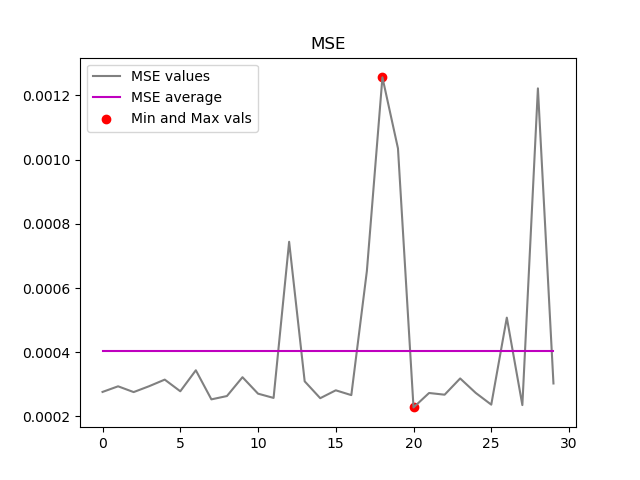

In [69]:
plot_mse(mse_list_100_70)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 100us/step
MSE: 0.014356716424226762


<IPython.core.display.Javascript object>


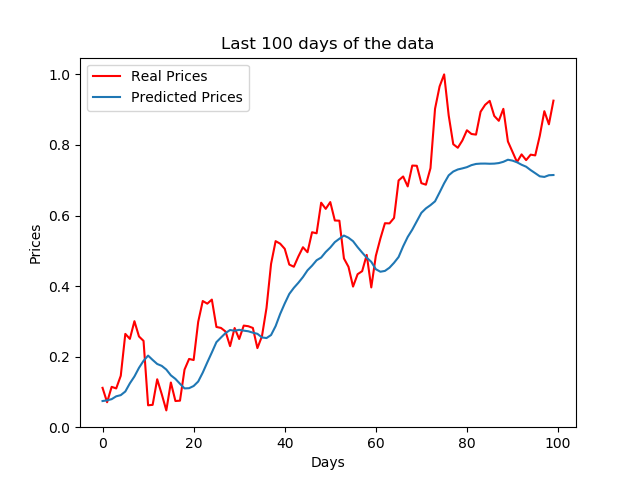

In [49]:
model1_100 = plot_predictions_and_real_prices_for_one_sample(model_100_70, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 37us/step
MSE: 0.0011268834332004189


<IPython.core.display.Javascript object>


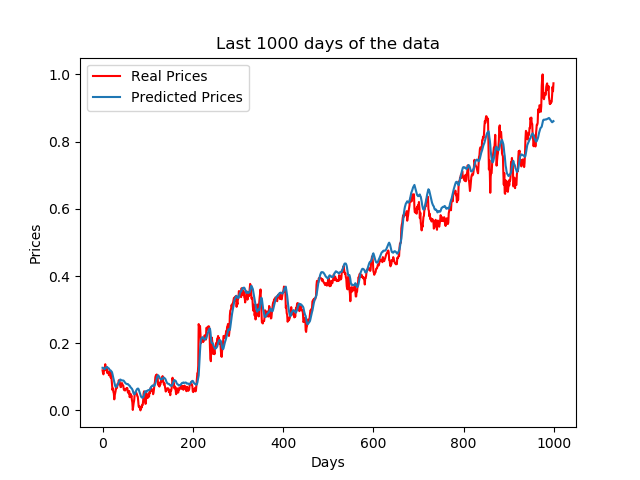

In [70]:
model1_1000 = plot_predictions_and_real_prices_for_one_sample(model_100_70, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 33us/step
MSE: 0.0007128667733049952


<IPython.core.display.Javascript object>


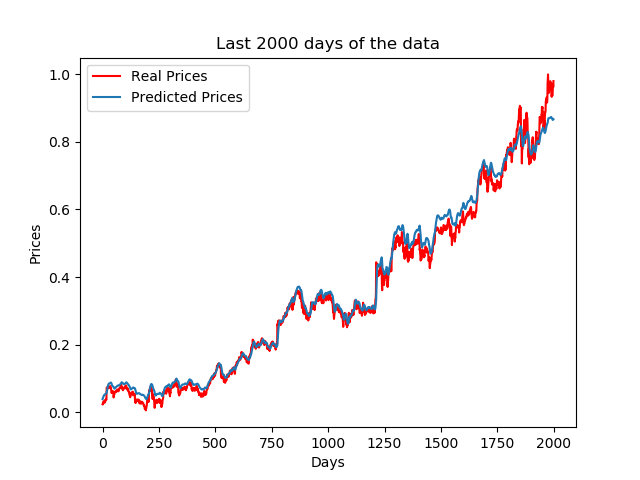

In [71]:
model1_2000 = plot_predictions_and_real_prices_for_one_sample(model_100_70, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# MODEL 2

## Training model 2: 

**(100 input samples extracted, 50% training and 50% testing)**

In [72]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_100_50[epoch].shape)
    print(y_train_all_100_50[epoch].shape)
    
    # fit the model to the current data
    model_100_50.fit(X_train_all_100_50[epoch],
                     y_train_all_100_50[epoch],
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(1090, 54, 1)
(1090, 1)
Epoch 1/50
1090/1090 [==============================] - 1s 882us/step - loss: 0.1525
Epoch 2/50
1090/1090 [==============================] - 0s 62us/step - loss: 0.1480
Epoch 3/50
1090/1090 [==============================] - 0s 64us/step - loss: 0.1424
Epoch 4/50
1090/1090 [==============================] - 0s 61us/step - loss: 0.1370
Epoch 5/50
1090/1090 [==============================] - 0s 53us/step - loss: 0.1316
Epoch 6/50
1090/1090 [==============================] - 0s 59us/step - loss: 0.1264
Epoch 7/50
1090/1090 [==============================] - 0s 52us/step - loss: 0.1212
Epoch 8/50
1090/1090 [==============================] - 0s 59us/step - loss: 0.1162
Epoch 9/50
1090/1090 [==============================] - 0s 61us/step - loss: 0.1113
Epoch 10/50
1090/1090 [==============================] - 0s 59us/step - loss: 0.1065
Epoch 11/50
1090/1090 [==============================] - 0s 57us/step - loss: 0.1018
Epoch 12/50
1090/1090 [==================

Epoch 42/50
1083/1083 [==============================] - 0s 75us/step - loss: 0.0013
Epoch 43/50
1083/1083 [==============================] - 0s 73us/step - loss: 0.0013
Epoch 44/50
1083/1083 [==============================] - 0s 85us/step - loss: 0.0013
Epoch 45/50
1083/1083 [==============================] - 0s 89us/step - loss: 0.0013
Epoch 46/50
1083/1083 [==============================] - ETA: 0s - loss: 0.001 - 0s 79us/step - loss: 0.0013
Epoch 47/50
1083/1083 [==============================] - 0s 76us/step - loss: 0.0013
Epoch 48/50
1083/1083 [==============================] - 0s 79us/step - loss: 0.0013
Epoch 49/50
1083/1083 [==============================] - 0s 80us/step - loss: 0.0013
Epoch 50/50
1083/1083 [==============================] - 0s 79us/step - loss: 0.0013
epoch=4
(1088, 59, 1)
(1088, 1)
Epoch 1/50
1088/1088 [==============================] - 0s 70us/step - loss: 0.0013
Epoch 2/50
1088/1088 [==============================] - 0s 63us/step - loss: 0.0013
Epoch 3/50


1070/1070 [==============================] - 0s 103us/step - loss: 8.0376e-04
Epoch 27/50
1070/1070 [==============================] - 0s 103us/step - loss: 8.0106e-04
Epoch 28/50
1070/1070 [==============================] - 0s 109us/step - loss: 7.9856e-04
Epoch 29/50
1070/1070 [==============================] - 0s 102us/step - loss: 7.9527e-04
Epoch 30/50
1070/1070 [==============================] - 0s 102us/step - loss: 7.9373e-04
Epoch 31/50
1070/1070 [==============================] - 0s 103us/step - loss: 7.9249e-04
Epoch 32/50
1070/1070 [==============================] - 0s 98us/step - loss: 7.8952e-04
Epoch 33/50
1070/1070 [==============================] - 0s 114us/step - loss: 7.8585e-04
Epoch 34/50
1070/1070 [==============================] - 0s 103us/step - loss: 7.8269e-04
Epoch 35/50
1070/1070 [==============================] - 0s 114us/step - loss: 7.8009e-04
Epoch 36/50
1070/1070 [==============================] - 0s 103us/step - loss: 7.7801e-04
Epoch 37/50
1070/1070 [

1086/1086 [==============================] - 0s 73us/step - loss: 5.0139e-04
Epoch 8/50
1086/1086 [==============================] - 0s 63us/step - loss: 5.0137e-04
Epoch 9/50
1086/1086 [==============================] - 0s 71us/step - loss: 5.0083e-04
Epoch 10/50
1086/1086 [==============================] - 0s 73us/step - loss: 5.0000e-04
Epoch 11/50
1086/1086 [==============================] - 0s 73us/step - loss: 4.9935e-04
Epoch 12/50
1086/1086 [==============================] - 0s 69us/step - loss: 4.9920e-04
Epoch 13/50
1086/1086 [==============================] - 0s 67us/step - loss: 4.9929e-04
Epoch 14/50
1086/1086 [==============================] - 0s 66us/step - loss: 4.9875e-04
Epoch 15/50
1086/1086 [==============================] - 0s 69us/step - loss: 4.9748e-04
Epoch 16/50
1086/1086 [==============================] - 0s 68us/step - loss: 4.9604e-04
Epoch 17/50
1086/1086 [==============================] - 0s 75us/step - loss: 4.9491e-04
Epoch 18/50
1086/1086 [============

1096/1096 [==============================] - 0s 41us/step - loss: 4.2470e-04
Epoch 40/50
1096/1096 [==============================] - 0s 44us/step - loss: 4.2470e-04
Epoch 41/50
1096/1096 [==============================] - 0s 43us/step - loss: 4.2386e-04
Epoch 42/50
1096/1096 [==============================] - 0s 46us/step - loss: 4.2216e-04
Epoch 43/50
1096/1096 [==============================] - 0s 44us/step - loss: 4.2047e-04
Epoch 44/50
1096/1096 [==============================] - 0s 44us/step - loss: 4.1979e-04
Epoch 45/50
1096/1096 [==============================] - 0s 49us/step - loss: 4.1956e-04
Epoch 46/50
1096/1096 [==============================] - 0s 42us/step - loss: 4.1898e-04
Epoch 47/50
1096/1096 [==============================] - 0s 47us/step - loss: 4.1788e-04
Epoch 48/50
1096/1096 [==============================] - 0s 59us/step - loss: 4.1663e-04
Epoch 49/50
1096/1096 [==============================] - 0s 49us/step - loss: 4.1549e-04
Epoch 50/50
1096/1096 [==========

1080/1080 [==============================] - 0s 79us/step - loss: 3.3901e-04
Epoch 31/50
1080/1080 [==============================] - 0s 82us/step - loss: 3.3963e-04
Epoch 32/50
1080/1080 [==============================] - 0s 83us/step - loss: 3.4096e-04
Epoch 33/50
1080/1080 [==============================] - 0s 85us/step - loss: 3.4048e-04
Epoch 34/50
1080/1080 [==============================] - 0s 89us/step - loss: 3.3874e-04
Epoch 35/50
1080/1080 [==============================] - 0s 82us/step - loss: 3.3767e-04
Epoch 36/50
1080/1080 [==============================] - 0s 85us/step - loss: 3.3644e-04
Epoch 37/50
1080/1080 [==============================] - 0s 81us/step - loss: 3.3534e-04
Epoch 38/50
1080/1080 [==============================] - 0s 86us/step - loss: 3.3415e-04
Epoch 39/50
1080/1080 [==============================] - 0s 86us/step - loss: 3.3357e-04
Epoch 40/50
1080/1080 [==============================] - 0s 80us/step - loss: 3.3450e-04
Epoch 41/50
1080/1080 [==========

1081/1081 [==============================] - 0s 87us/step - loss: 3.5636e-04
Epoch 13/50
1081/1081 [==============================] - 0s 78us/step - loss: 3.7765e-04
Epoch 14/50
1081/1081 [==============================] - 0s 84us/step - loss: 3.7351e-04
Epoch 15/50
1081/1081 [==============================] - 0s 76us/step - loss: 3.5146e-04
Epoch 16/50
1081/1081 [==============================] - 0s 87us/step - loss: 3.3047e-04
Epoch 17/50
1081/1081 [==============================] - 0s 74us/step - loss: 3.2182e-04
Epoch 18/50
1081/1081 [==============================] - 0s 77us/step - loss: 3.2494e-04
Epoch 19/50
1081/1081 [==============================] - 0s 83us/step - loss: 3.3043e-04
Epoch 20/50
1081/1081 [==============================] - 0s 80us/step - loss: 3.3108e-04
Epoch 21/50
1081/1081 [==============================] - 0s 78us/step - loss: 3.2530e-04
Epoch 22/50
1081/1081 [==============================] - 0s 77us/step - loss: 3.2077e-04
Epoch 23/50
1081/1081 [==========

1081/1081 [==============================] - 0s 74us/step - loss: 2.5367e-04
Epoch 45/50
1081/1081 [==============================] - 0s 75us/step - loss: 2.5404e-04
Epoch 46/50
1081/1081 [==============================] - 0s 73us/step - loss: 2.5413e-04
Epoch 47/50
1081/1081 [==============================] - 0s 88us/step - loss: 2.5371e-04
Epoch 48/50
1081/1081 [==============================] - 0s 80us/step - loss: 2.5329e-04
Epoch 49/50
1081/1081 [==============================] - 0s 77us/step - loss: 2.5299e-04
Epoch 50/50
1081/1081 [==============================] - 0s 77us/step - loss: 2.5310e-04
epoch=24
(1098, 39, 1)
(1098, 1)
Epoch 1/50
1098/1098 [==============================] - 0s 39us/step - loss: 2.6846e-04
Epoch 2/50
1098/1098 [==============================] - 0s 42us/step - loss: 2.6841e-04
Epoch 3/50
1098/1098 [==============================] - 0s 49us/step - loss: 2.6844e-04
Epoch 4/50
1098/1098 [==============================] - 0s 43us/step - loss: 2.6822e-04
Epoc

1090/1090 [==============================] - 0s 59us/step - loss: 2.5625e-04
Epoch 27/50
1090/1090 [==============================] - 0s 62us/step - loss: 2.5695e-04
Epoch 28/50
1090/1090 [==============================] - 0s 54us/step - loss: 2.5703e-04
Epoch 29/50
1090/1090 [==============================] - 0s 59us/step - loss: 2.5647e-04
Epoch 30/50
1090/1090 [==============================] - 0s 55us/step - loss: 2.5553e-04
Epoch 31/50
1090/1090 [==============================] - 0s 54us/step - loss: 2.5569e-04
Epoch 32/50
1090/1090 [==============================] - 0s 55us/step - loss: 2.5691e-04
Epoch 33/50
1090/1090 [==============================] - 0s 61us/step - loss: 2.5729e-04
Epoch 34/50
1090/1090 [==============================] - 0s 58us/step - loss: 2.5604e-04
Epoch 35/50
1090/1090 [==============================] - 0s 58us/step - loss: 2.5459e-04
Epoch 36/50
1090/1090 [==============================] - 0s 56us/step - loss: 2.5581e-04
Epoch 37/50
1090/1090 [==========

## Testing model 2:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_100_50, X_test_all_100_50, y_test_all_100_50)

In [74]:
mse_list_100_50 = mse_list(model_100_50, X_test_all_100_50, y_test_all_100_50, lengths)

Max mse: 0.0010827963051728193 (related window: 13)
Min mse: 0.00022950271094182245 (related window: 94)
Average mse: 0.00037566258027732876


<IPython.core.display.Javascript object>


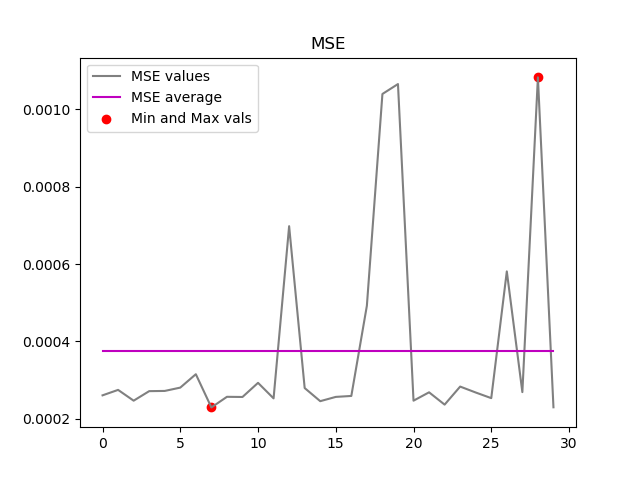

In [75]:
plot_mse(mse_list_100_50)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 100us/step
MSE: 0.008198167011141778


<IPython.core.display.Javascript object>


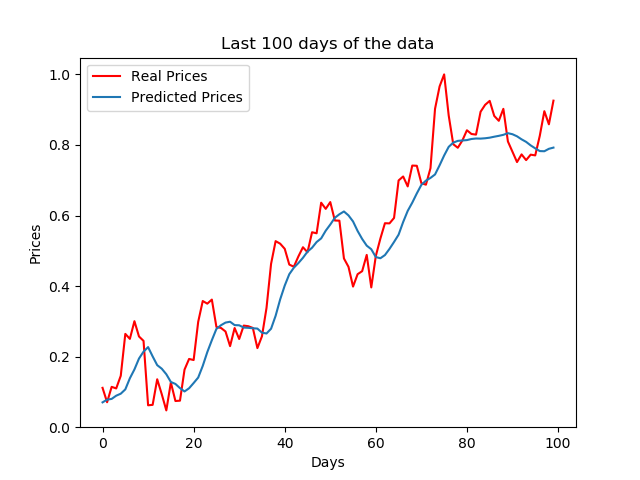

In [77]:
model2_100 = plot_predictions_and_real_prices_for_one_sample(model_100_50, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 58us/step
MSE: 0.0010071732797659935


<IPython.core.display.Javascript object>


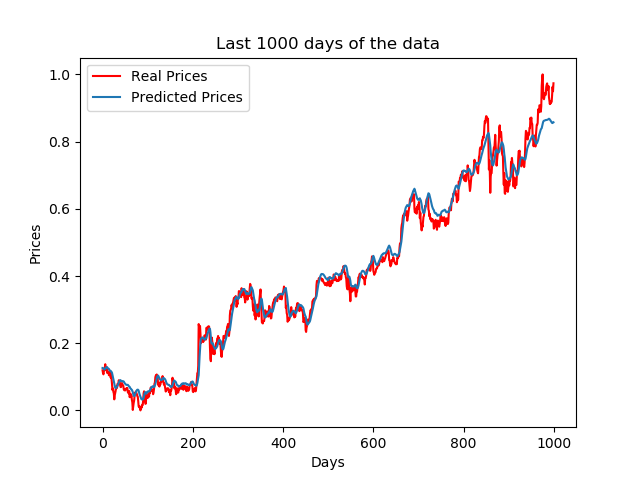

In [78]:
model2_1000 = plot_predictions_and_real_prices_for_one_sample(model_100_50, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 39us/step
MSE: 0.0005754465326026548


<IPython.core.display.Javascript object>


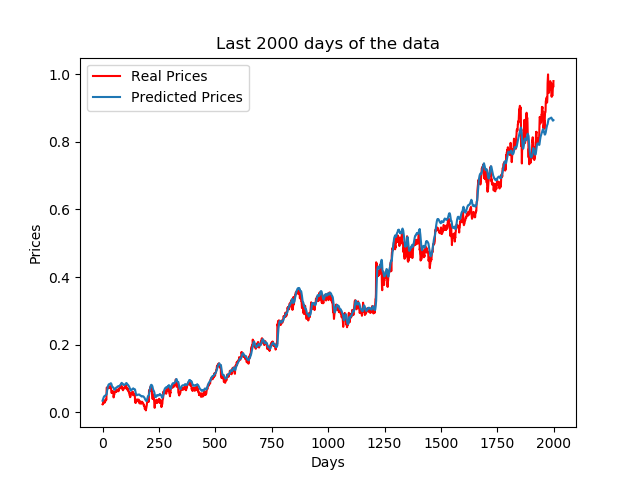

In [79]:
model2_2000 = plot_predictions_and_real_prices_for_one_sample(model_100_50, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# Model 3

## Training model 3:

**(1000 input samples extracted, 70% training and 30% testing)**

In [80]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_1000_70[epoch].shape)
    print(y_train_all_1000_70[epoch].shape)
    
    # fit the model to the current data
    model_1000_70.fit(X_train_all_1000_70[epoch],
                      y_train_all_1000_70[epoch],
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE)
    
    
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(896, 54, 1)
(896, 1)
Epoch 1/50
896/896 [==============================] - 1s 1ms/step - loss: 0.2328
Epoch 2/50
896/896 [==============================] - 0s 43us/step - loss: 0.2303
Epoch 3/50
896/896 [==============================] - 0s 41us/step - loss: 0.2269
Epoch 4/50
896/896 [==============================] - 0s 42us/step - loss: 0.2236
Epoch 5/50
896/896 [==============================] - 0s 38us/step - loss: 0.2203
Epoch 6/50
896/896 [==============================] - 0s 45us/step - loss: 0.2170
Epoch 7/50
896/896 [==============================] - 0s 39us/step - loss: 0.2138
Epoch 8/50
896/896 [==============================] - 0s 49us/step - loss: 0.2106
Epoch 9/50
896/896 [==============================] - 0s 40us/step - loss: 0.2074
Epoch 10/50
896/896 [==============================] - 0s 45us/step - loss: 0.2043
Epoch 11/50
896/896 [==============================] - 0s 40us/step - loss: 0.2012
Epoch 12/50
896/896 [==============================] - 0s 36us/step

Epoch 50/50
868/868 [==============================] - 0s 72us/step - loss: 0.0259
epoch=2
(911, 33, 1)
(911, 1)
Epoch 1/50
911/911 [==============================] - 0s 28us/step - loss: 0.0260
Epoch 2/50
911/911 [==============================] - 0s 25us/step - loss: 0.0253
Epoch 3/50
911/911 [==============================] - 0s 25us/step - loss: 0.0247
Epoch 4/50
911/911 [==============================] - 0s 24us/step - loss: 0.0241
Epoch 5/50
911/911 [==============================] - 0s 34us/step - loss: 0.0235
Epoch 6/50
911/911 [==============================] - 0s 25us/step - loss: 0.0229
Epoch 7/50
911/911 [==============================] - 0s 24us/step - loss: 0.0224
Epoch 8/50
911/911 [==============================] - 0s 27us/step - loss: 0.0220
Epoch 9/50
911/911 [==============================] - 0s 23us/step - loss: 0.0215
Epoch 10/50
911/911 [==============================] - 0s 27us/step - loss: 0.0211
Epoch 11/50
911/911 [==============================] - 0s 30us/ste

Epoch 49/50
886/886 [==============================] - 0s 42us/step - loss: 0.0041
Epoch 50/50
886/886 [==============================] - 0s 54us/step - loss: 0.0040
epoch=4
(893, 59, 1)
(893, 1)
Epoch 1/50
893/893 [==============================] - 0s 45us/step - loss: 0.0042
Epoch 2/50
893/893 [==============================] - 0s 44us/step - loss: 0.0041
Epoch 3/50
893/893 [==============================] - 0s 42us/step - loss: 0.0040
Epoch 4/50
893/893 [==============================] - 0s 46us/step - loss: 0.0040
Epoch 5/50
893/893 [==============================] - 0s 44us/step - loss: 0.0039
Epoch 6/50
893/893 [==============================] - 0s 42us/step - loss: 0.0038
Epoch 7/50
893/893 [==============================] - 0s 48us/step - loss: 0.0038
Epoch 8/50
893/893 [==============================] - 0s 51us/step - loss: 0.0037
Epoch 9/50
893/893 [==============================] - 0s 48us/step - loss: 0.0037
Epoch 10/50
893/893 [==============================] - 0s 45us/ste

Epoch 48/50
874/874 [==============================] - 0s 60us/step - loss: 0.0020
Epoch 49/50
874/874 [==============================] - 0s 68us/step - loss: 0.0020
Epoch 50/50
874/874 [==============================] - 0s 60us/step - loss: 0.0020
epoch=6
(915, 27, 1)
(915, 1)
Epoch 1/50
915/915 [==============================] - 0s 26us/step - loss: 0.0048
Epoch 2/50
915/915 [==============================] - 0s 25us/step - loss: 0.0047
Epoch 3/50
915/915 [==============================] - 0s 23us/step - loss: 0.0046
Epoch 4/50
915/915 [==============================] - 0s 23us/step - loss: 0.0044
Epoch 5/50
915/915 [==============================] - 0s 20us/step - loss: 0.0042
Epoch 6/50
915/915 [==============================] - 0s 22us/step - loss: 0.0040
Epoch 7/50
915/915 [==============================] - 0s 23us/step - loss: 0.0038
Epoch 8/50
915/915 [==============================] - 0s 20us/step - loss: 0.0037
Epoch 9/50
915/915 [==============================] - 0s 25us/ste

Epoch 47/50
868/868 [==============================] - 0s 72us/step - loss: 0.0018
Epoch 48/50
868/868 [==============================] - 0s 68us/step - loss: 0.0018
Epoch 49/50
868/868 [==============================] - 0s 72us/step - loss: 0.0018
Epoch 50/50
868/868 [==============================] - 0s 69us/step - loss: 0.0018
epoch=8
(870, 92, 1)
(870, 1)
Epoch 1/50
870/870 [==============================] - 0s 66us/step - loss: 0.0019
Epoch 2/50
870/870 [==============================] - 0s 65us/step - loss: 0.0019
Epoch 3/50
870/870 [==============================] - 0s 65us/step - loss: 0.0019
Epoch 4/50
870/870 [==============================] - 0s 70us/step - loss: 0.0019
Epoch 5/50
870/870 [==============================] - 0s 76us/step - loss: 0.0019
Epoch 6/50
870/870 [==============================] - 0s 75us/step - loss: 0.0018
Epoch 7/50
870/870 [==============================] - 0s 68us/step - loss: 0.0018
Epoch 8/50
870/870 [==============================] - 0s 68us/st

Epoch 46/50
873/873 [==============================] - 0s 67us/step - loss: 0.0017
Epoch 47/50
873/873 [==============================] - 0s 65us/step - loss: 0.0017
Epoch 48/50
873/873 [==============================] - 0s 66us/step - loss: 0.0017
Epoch 49/50
873/873 [==============================] - 0s 65us/step - loss: 0.0017
Epoch 50/50
873/873 [==============================] - 0s 59us/step - loss: 0.0017
epoch=10
(881, 76, 1)
(881, 1)
Epoch 1/50
881/881 [==============================] - 0s 57us/step - loss: 0.0016
Epoch 2/50
881/881 [==============================] - 0s 55us/step - loss: 0.0016
Epoch 3/50
881/881 [==============================] - 0s 52us/step - loss: 0.0016
Epoch 4/50
881/881 [==============================] - 0s 63us/step - loss: 0.0016
Epoch 5/50
881/881 [==============================] - 0s 63us/step - loss: 0.0016
Epoch 6/50
881/881 [==============================] - 0s 61us/step - loss: 0.0016
Epoch 7/50
881/881 [==============================] - 0s 55us/

Epoch 45/50
890/890 [==============================] - 0s 47us/step - loss: 0.0016
Epoch 46/50
890/890 [==============================] - 0s 55us/step - loss: 0.0016
Epoch 47/50
890/890 [==============================] - 0s 47us/step - loss: 0.0016
Epoch 48/50
890/890 [==============================] - 0s 45us/step - loss: 0.0016
Epoch 49/50
890/890 [==============================] - 0s 47us/step - loss: 0.0016
Epoch 50/50
890/890 [==============================] - 0s 48us/step - loss: 0.0016
epoch=12
(920, 20, 1)
(920, 1)
Epoch 1/50
920/920 [==============================] - 0s 17us/step - loss: 0.0043
Epoch 2/50
920/920 [==============================] - 0s 20us/step - loss: 0.0043
Epoch 3/50
920/920 [==============================] - 0s 16us/step - loss: 0.0042
Epoch 4/50
920/920 [==============================] - 0s 16us/step - loss: 0.0040
Epoch 5/50
920/920 [==============================] - 0s 14us/step - loss: 0.0039
Epoch 6/50
920/920 [==============================] - 0s 20us

Epoch 44/50
914/914 [==============================] - 0s 22us/step - loss: 0.0015
Epoch 45/50
914/914 [==============================] - 0s 25us/step - loss: 0.0015
Epoch 46/50
914/914 [==============================] - 0s 19us/step - loss: 0.0015
Epoch 47/50
914/914 [==============================] - 0s 27us/step - loss: 0.0015
Epoch 48/50
914/914 [==============================] - 0s 20us/step - loss: 0.0015
Epoch 49/50
914/914 [==============================] - 0s 23us/step - loss: 0.0015
Epoch 50/50
914/914 [==============================] - 0s 22us/step - loss: 0.0015
epoch=14
(904, 43, 1)
(904, 1)
Epoch 1/50
904/904 [==============================] - 0s 33us/step - loss: 0.0019
Epoch 2/50
904/904 [==============================] - 0s 32us/step - loss: 0.0019
Epoch 3/50
904/904 [==============================] - 0s 31us/step - loss: 0.0018
Epoch 4/50
904/904 [==============================] - 0s 34us/step - loss: 0.0018
Epoch 5/50
904/904 [==============================] - 0s 34u

Epoch 43/50
865/865 [==============================] - 0s 71us/step - loss: 0.0014
Epoch 44/50
865/865 [==============================] - 0s 81us/step - loss: 0.0014
Epoch 45/50
865/865 [==============================] - 0s 76us/step - loss: 0.0014
Epoch 46/50
865/865 [==============================] - 0s 81us/step - loss: 0.0014
Epoch 47/50
865/865 [==============================] - 0s 73us/step - loss: 0.0014
Epoch 48/50
865/865 [==============================] - 0s 78us/step - loss: 0.0014
Epoch 49/50
865/865 [==============================] - 0s 71us/step - loss: 0.0014
Epoch 50/50
865/865 [==============================] - 0s 70us/step - loss: 0.0014
epoch=16
(882, 75, 1)
(882, 1)
Epoch 1/50
882/882 [==============================] - 0s 64us/step - loss: 0.0013
Epoch 2/50
882/882 [==============================] - 0s 51us/step - loss: 0.0013
Epoch 3/50
882/882 [==============================] - 0s 57us/step - loss: 0.0013
Epoch 4/50
882/882 [==============================] - 0s 55

Epoch 42/50
927/927 [==============================] - 0s 11us/step - loss: 0.0043
Epoch 43/50
927/927 [==============================] - 0s 10us/step - loss: 0.0042
Epoch 44/50
927/927 [==============================] - 0s 9us/step - loss: 0.0040
Epoch 45/50
927/927 [==============================] - 0s 10us/step - loss: 0.0039
Epoch 46/50
927/927 [==============================] - 0s 11us/step - loss: 0.0038
Epoch 47/50
927/927 [==============================] - 0s 10us/step - loss: 0.0037
Epoch 48/50
927/927 [==============================] - 0s 10us/step - loss: 0.0036
Epoch 49/50
927/927 [==============================] - 0s 10us/step - loss: 0.0035
Epoch 50/50
927/927 [==============================] - 0s 9us/step - loss: 0.0035
epoch=18
(925, 13, 1)
(925, 1)
Epoch 1/50
925/925 [==============================] - 0s 17us/step - loss: 0.0045
Epoch 2/50
925/925 [==============================] - 0s 14us/step - loss: 0.0043
Epoch 3/50
925/925 [==============================] - 0s 11u

Epoch 41/50
922/922 [==============================] - 0s 14us/step - loss: 0.0012
Epoch 42/50
922/922 [==============================] - 0s 13us/step - loss: 0.0012
Epoch 43/50
922/922 [==============================] - 0s 14us/step - loss: 0.0012
Epoch 44/50
922/922 [==============================] - 0s 16us/step - loss: 0.0012
Epoch 45/50
922/922 [==============================] - 0s 13us/step - loss: 0.0012
Epoch 46/50
922/922 [==============================] - 0s 13us/step - loss: 0.0012
Epoch 47/50
922/922 [==============================] - 0s 30us/step - loss: 0.0012
Epoch 48/50
922/922 [==============================] - 0s 15us/step - loss: 0.0012
Epoch 49/50
922/922 [==============================] - 0s 12us/step - loss: 0.0012
Epoch 50/50
922/922 [==============================] - 0s 13us/step - loss: 0.0012
epoch=20
(884, 72, 1)
(884, 1)
Epoch 1/50
884/884 [==============================] - 0s 58us/step - loss: 0.0023
Epoch 2/50
884/884 [==============================] - 0s 

Epoch 39/50
887/887 [==============================] - 0s 45us/step - loss: 0.0011
Epoch 40/50
887/887 [==============================] - 0s 61us/step - loss: 0.0011
Epoch 41/50
887/887 [==============================] - 0s 48us/step - loss: 0.0011
Epoch 42/50
887/887 [==============================] - 0s 49us/step - loss: 0.0011
Epoch 43/50
887/887 [==============================] - 0s 56us/step - loss: 0.0011
Epoch 44/50
887/887 [==============================] - 0s 46us/step - loss: 0.0011
Epoch 45/50
887/887 [==============================] - 0s 52us/step - loss: 0.0011
Epoch 46/50
887/887 [==============================] - 0s 56us/step - loss: 0.0011
Epoch 47/50
887/887 [==============================] - 0s 56us/step - loss: 0.0011
Epoch 48/50
887/887 [==============================] - 0s 51us/step - loss: 0.0011
Epoch 49/50
887/887 [==============================] - 0s 58us/step - loss: 0.0011
Epoch 50/50
887/887 [==============================] - 0s 61us/step - loss: 0.0011
epoc

Epoch 38/50
884/884 [==============================] - 0s 51us/step - loss: 0.0010
Epoch 39/50
884/884 [==============================] - 0s 58us/step - loss: 0.0010
Epoch 40/50
884/884 [==============================] - 0s 60us/step - loss: 0.0010
Epoch 41/50
884/884 [==============================] - 0s 47us/step - loss: 0.0010
Epoch 42/50
884/884 [==============================] - 0s 59us/step - loss: 0.0010
Epoch 43/50
884/884 [==============================] - 0s 53us/step - loss: 0.0010
Epoch 44/50
884/884 [==============================] - 0s 56us/step - loss: 0.0010
Epoch 45/50
884/884 [==============================] - 0s 58us/step - loss: 0.0010
Epoch 46/50
884/884 [==============================] - 0s 59us/step - loss: 0.0010
Epoch 47/50
884/884 [==============================] - 0s 56us/step - loss: 0.0010
Epoch 48/50
884/884 [==============================] - 0s 58us/step - loss: 0.0010
Epoch 49/50
884/884 [==============================] - 0s 58us/step - loss: 0.0010
Epoc

Epoch 30/50
896/896 [==============================] - 0s 37us/step - loss: 0.0011
Epoch 31/50
896/896 [==============================] - 0s 42us/step - loss: 0.0011
Epoch 32/50
896/896 [==============================] - 0s 39us/step - loss: 0.0011
Epoch 33/50
896/896 [==============================] - 0s 42us/step - loss: 0.0011
Epoch 34/50
896/896 [==============================] - 0s 48us/step - loss: 0.0011
Epoch 35/50
896/896 [==============================] - 0s 41us/step - loss: 0.0011
Epoch 36/50
896/896 [==============================] - 0s 41us/step - loss: 0.0011
Epoch 37/50
896/896 [==============================] - 0s 36us/step - loss: 0.0011
Epoch 38/50
896/896 [==============================] - 0s 45us/step - loss: 0.0011
Epoch 39/50
896/896 [==============================] - 0s 46us/step - loss: 0.0011
Epoch 40/50
896/896 [==============================] - 0s 40us/step - loss: 0.0011
Epoch 41/50
896/896 [==============================] - 0s 39us/step - loss: 0.0011
Epoc

Epoch 27/50
894/894 [==============================] - 0s 47us/step - loss: 9.4834e-04
Epoch 28/50
894/894 [==============================] - 0s 46us/step - loss: 9.3840e-04
Epoch 29/50
894/894 [==============================] - 0s 44us/step - loss: 9.3336e-04
Epoch 30/50
894/894 [==============================] - 0s 36us/step - loss: 9.3238e-04
Epoch 31/50
894/894 [==============================] - 0s 42us/step - loss: 9.3436e-04
Epoch 32/50
894/894 [==============================] - 0s 47us/step - loss: 9.3811e-04
Epoch 33/50
894/894 [==============================] - 0s 46us/step - loss: 9.4250e-04
Epoch 34/50
894/894 [==============================] - 0s 50us/step - loss: 9.4657e-04
Epoch 35/50
894/894 [==============================] - 0s 41us/step - loss: 9.4961e-04
Epoch 36/50
894/894 [==============================] - 0s 42us/step - loss: 9.5118e-04
Epoch 37/50
894/894 [==============================] - 0s 45us/step - loss: 9.5112e-04
Epoch 38/50
894/894 [======================

## Testing model 3:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_1000_70, X_test_all_1000_70, y_test_all_1000_70)

In [82]:
mse_list_1000_70 = mse_list(model_1000_70, X_test_all_1000_70, y_test_all_1000_70, lengths)

Max mse: 0.0025825324911745873 (related window: 9)
Min mse: 0.000804729360379377 (related window: 72)
Average mse: 0.0011479784718520416


<IPython.core.display.Javascript object>


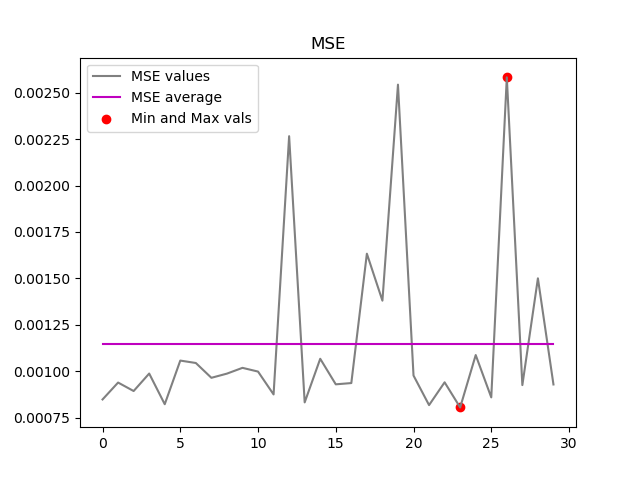

In [83]:
plot_mse(mse_list_1000_70)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 90us/step
MSE: 0.01078449334949255


<IPython.core.display.Javascript object>


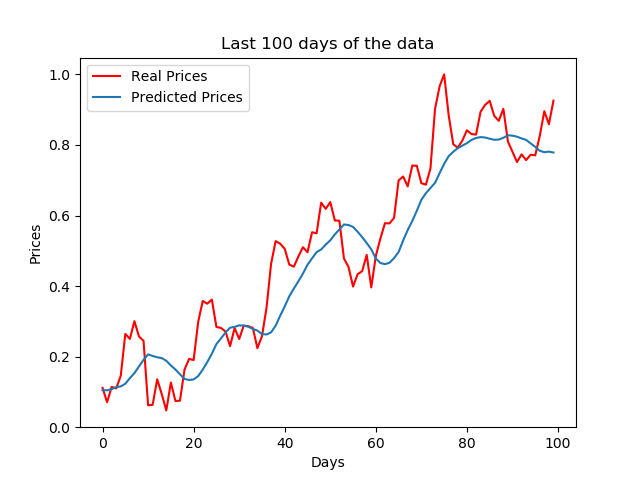

In [84]:
model3_100 = plot_predictions_and_real_prices_for_one_sample(model_1000_70, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 42us/step
MSE: 0.0014739812756888568


<IPython.core.display.Javascript object>


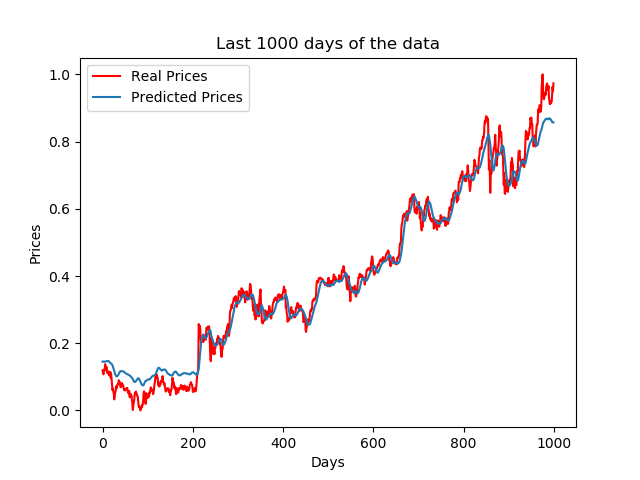

In [85]:
model3_1000 = plot_predictions_and_real_prices_for_one_sample(model_1000_70, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 45us/step
MSE: 0.0010499059561407194


<IPython.core.display.Javascript object>


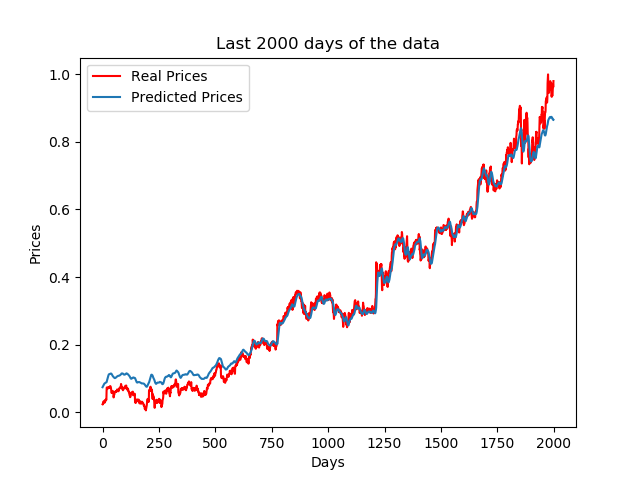

In [86]:
model3_2000 = plot_predictions_and_real_prices_for_one_sample(model_1000_70, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# MODEL 4

## Training model 4:

**(1000 input samples extracted, 50% training and 50% testing)**

In [87]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_1000_50[epoch].shape)
    print(y_train_all_1000_50[epoch].shape)
    
    # fit the model to the current data
    model_1000_50.fit(X_train_all_1000_50[epoch],
                      y_train_all_1000_50[epoch],
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(640, 54, 1)
(640, 1)
Epoch 1/50
640/640 [==============================] - 1s 2ms/step - loss: 0.2321
Epoch 2/50
640/640 [==============================] - 0s 53us/step - loss: 0.2289
Epoch 3/50
640/640 [==============================] - 0s 50us/step - loss: 0.2258
Epoch 4/50
640/640 [==============================] - 0s 53us/step - loss: 0.2227
Epoch 5/50
640/640 [==============================] - 0s 51us/step - loss: 0.2198
Epoch 6/50
640/640 [==============================] - 0s 50us/step - loss: 0.2167
Epoch 7/50
640/640 [==============================] - 0s 53us/step - loss: 0.2136
Epoch 8/50
640/640 [==============================] - 0s 50us/step - loss: 0.2105
Epoch 9/50
640/640 [==============================] - 0s 51us/step - loss: 0.2075
Epoch 10/50
640/640 [==============================] - 0s 45us/step - loss: 0.2044
Epoch 11/50
640/640 [==============================] - 0s 56us/step - loss: 0.2014
Epoch 12/50
640/640 [==============================] - 0s 50us/step

Epoch 50/50
620/620 [==============================] - 0s 82us/step - loss: 0.0252
epoch=2
(651, 33, 1)
(651, 1)
Epoch 1/50
651/651 [==============================] - 0s 29us/step - loss: 0.0259
Epoch 2/50
651/651 [==============================] - 0s 29us/step - loss: 0.0255
Epoch 3/50
651/651 [==============================] - 0s 26us/step - loss: 0.0252
Epoch 4/50
651/651 [==============================] - 0s 32us/step - loss: 0.0249
Epoch 5/50
651/651 [==============================] - 0s 29us/step - loss: 0.0246
Epoch 6/50
651/651 [==============================] - 0s 26us/step - loss: 0.0243
Epoch 7/50
651/651 [==============================] - 0s 32us/step - loss: 0.0240
Epoch 8/50
651/651 [==============================] - 0s 32us/step - loss: 0.0238
Epoch 9/50
651/651 [==============================] - 0s 44us/step - loss: 0.0235
Epoch 10/50
651/651 [==============================] - 0s 32us/step - loss: 0.0233
Epoch 11/50
651/651 [==============================] - 0s 38us/ste

Epoch 49/50
633/633 [==============================] - 0s 52us/step - loss: 0.0077
Epoch 50/50
633/633 [==============================] - 0s 50us/step - loss: 0.0076
epoch=4
(638, 59, 1)
(638, 1)
Epoch 1/50
638/638 [==============================] - 0s 50us/step - loss: 0.0074
Epoch 2/50
638/638 [==============================] - 0s 52us/step - loss: 0.0073
Epoch 3/50
638/638 [==============================] - 0s 50us/step - loss: 0.0072
Epoch 4/50
638/638 [==============================] - 0s 61us/step - loss: 0.0071
Epoch 5/50
638/638 [==============================] - 0s 53us/step - loss: 0.0069
Epoch 6/50
638/638 [==============================] - 0s 61us/step - loss: 0.0068
Epoch 7/50
638/638 [==============================] - 0s 52us/step - loss: 0.0067
Epoch 8/50
638/638 [==============================] - 0s 48us/step - loss: 0.0066
Epoch 9/50
638/638 [==============================] - 0s 53us/step - loss: 0.0065
Epoch 10/50
638/638 [==============================] - 0s 56us/ste

Epoch 48/50
624/624 [==============================] - 0s 72us/step - loss: 0.0021
Epoch 49/50
624/624 [==============================] - 0s 74us/step - loss: 0.0021
Epoch 50/50
624/624 [==============================] - 0s 67us/step - loss: 0.0021
epoch=6
(654, 27, 1)
(654, 1)
Epoch 1/50
654/654 [==============================] - 0s 23us/step - loss: 0.0029
Epoch 2/50
654/654 [==============================] - 0s 23us/step - loss: 0.0029
Epoch 3/50
654/654 [==============================] - 0s 21us/step - loss: 0.0029
Epoch 4/50
654/654 [==============================] - 0s 27us/step - loss: 0.0028
Epoch 5/50
654/654 [==============================] - 0s 27us/step - loss: 0.0028
Epoch 6/50
654/654 [==============================] - 0s 24us/step - loss: 0.0027
Epoch 7/50
654/654 [==============================] - 0s 26us/step - loss: 0.0027
Epoch 8/50
654/654 [==============================] - 0s 24us/step - loss: 0.0026
Epoch 9/50
654/654 [==============================] - 0s 26us/ste

Epoch 47/50
620/620 [==============================] - 0s 77us/step - loss: 0.0016
Epoch 48/50
620/620 [==============================] - 0s 80us/step - loss: 0.0016
Epoch 49/50
620/620 [==============================] - 0s 92us/step - loss: 0.0016
Epoch 50/50
620/620 [==============================] - 0s 88us/step - loss: 0.0016
epoch=8
(621, 92, 1)
(621, 1)
Epoch 1/50
621/621 [==============================] - 0s 87us/step - loss: 0.0014
Epoch 2/50
621/621 [==============================] - 0s 95us/step - loss: 0.0014
Epoch 3/50
621/621 [==============================] - 0s 80us/step - loss: 0.0014
Epoch 4/50
621/621 [==============================] - 0s 85us/step - loss: 0.0014
Epoch 5/50
621/621 [==============================] - 0s 85us/step - loss: 0.0014
Epoch 6/50
621/621 [==============================] - 0s 77us/step - loss: 0.0014
Epoch 7/50
621/621 [==============================] - 0s 84us/step - loss: 0.0014
Epoch 8/50
621/621 [==============================] - 0s 93us/st

Epoch 46/50
624/624 [==============================] - 0s 93us/step - loss: 0.0014
Epoch 47/50
624/624 [==============================] - 0s 75us/step - loss: 0.0014
Epoch 48/50
624/624 [==============================] - 0s 88us/step - loss: 0.0013
Epoch 49/50
624/624 [==============================] - 0s 83us/step - loss: 0.0013
Epoch 50/50
624/624 [==============================] - 0s 74us/step - loss: 0.0013
epoch=10
(629, 76, 1)
(629, 1)
Epoch 1/50
629/629 [==============================] - 0s 65us/step - loss: 0.0013
Epoch 2/50
629/629 [==============================] - 0s 70us/step - loss: 0.0013
Epoch 3/50
629/629 [==============================] - 0s 67us/step - loss: 0.0013
Epoch 4/50
629/629 [==============================] - 0s 73us/step - loss: 0.0013
Epoch 5/50
629/629 [==============================] - 0s 76us/step - loss: 0.0013
Epoch 6/50
629/629 [==============================] - 0s 67us/step - loss: 0.0013
Epoch 7/50
629/629 [==============================] - 0s 67us/

Epoch 45/50
636/636 [==============================] - 0s 58us/step - loss: 0.0013
Epoch 46/50
636/636 [==============================] - 0s 53us/step - loss: 0.0013
Epoch 47/50
636/636 [==============================] - 0s 75us/step - loss: 0.0013
Epoch 48/50
636/636 [==============================] - 0s 61us/step - loss: 0.0013
Epoch 49/50
636/636 [==============================] - 0s 58us/step - loss: 0.0013
Epoch 50/50
636/636 [==============================] - 0s 64us/step - loss: 0.0013
epoch=12
(657, 20, 1)
(657, 1)
Epoch 1/50
657/657 [==============================] - 0s 21us/step - loss: 0.0026
Epoch 2/50
657/657 [==============================] - 0s 20us/step - loss: 0.0026
Epoch 3/50
657/657 [==============================] - 0s 18us/step - loss: 0.0025
Epoch 4/50
657/657 [==============================] - 0s 20us/step - loss: 0.0024
Epoch 5/50
657/657 [==============================] - 0s 20us/step - loss: 0.0023
Epoch 6/50
657/657 [==============================] - 0s 18us

Epoch 44/50
653/653 [==============================] - 0s 24us/step - loss: 0.0011
Epoch 45/50
653/653 [==============================] - 0s 29us/step - loss: 0.0011
Epoch 46/50
653/653 [==============================] - 0s 26us/step - loss: 0.0011
Epoch 47/50
653/653 [==============================] - 0s 29us/step - loss: 0.0011
Epoch 48/50
653/653 [==============================] - 0s 23us/step - loss: 0.0011
Epoch 49/50
653/653 [==============================] - 0s 24us/step - loss: 0.0011
Epoch 50/50
653/653 [==============================] - 0s 29us/step - loss: 0.0011
epoch=14
(646, 43, 1)
(646, 1)
Epoch 1/50
646/646 [==============================] - 0s 36us/step - loss: 0.0012
Epoch 2/50
646/646 [==============================] - 0s 45us/step - loss: 0.0012
Epoch 3/50
646/646 [==============================] - 0s 46us/step - loss: 0.0012
Epoch 4/50
646/646 [==============================] - 0s 37us/step - loss: 0.0012
Epoch 5/50
646/646 [==============================] - 0s 40u

Epoch 43/50
618/618 [==============================] - 0s 90us/step - loss: 0.0012
Epoch 44/50
618/618 [==============================] - 0s 82us/step - loss: 0.0012
Epoch 45/50
618/618 [==============================] - 0s 79us/step - loss: 0.0012
Epoch 46/50
618/618 [==============================] - 0s 90us/step - loss: 0.0012
Epoch 47/50
618/618 [==============================] - 0s 79us/step - loss: 0.0012
Epoch 48/50
618/618 [==============================] - 0s 94us/step - loss: 0.0012
Epoch 49/50
618/618 [==============================] - 0s 89us/step - loss: 0.0012
Epoch 50/50
618/618 [==============================] - 0s 82us/step - loss: 0.0012
epoch=16
(630, 75, 1)
(630, 1)
Epoch 1/50
630/630 [==============================] - 0s 62us/step - loss: 0.0011
Epoch 2/50
630/630 [==============================] - 0s 66us/step - loss: 0.0011
Epoch 3/50
630/630 [==============================] - 0s 70us/step - loss: 0.0011
Epoch 4/50
630/630 [==============================] - 0s 71

Epoch 42/50
662/662 [==============================] - 0s 12us/step - loss: 0.0026
Epoch 43/50
662/662 [==============================] - 0s 11us/step - loss: 0.0026
Epoch 44/50
662/662 [==============================] - 0s 14us/step - loss: 0.0025
Epoch 45/50
662/662 [==============================] - 0s 11us/step - loss: 0.0025
Epoch 46/50
662/662 [==============================] - 0s 11us/step - loss: 0.0024
Epoch 47/50
662/662 [==============================] - 0s 11us/step - loss: 0.0024
Epoch 48/50
662/662 [==============================] - 0s 14us/step - loss: 0.0023
Epoch 49/50
662/662 [==============================] - 0s 15us/step - loss: 0.0023
Epoch 50/50
662/662 [==============================] - 0s 11us/step - loss: 0.0023
epoch=18
(661, 13, 1)
(661, 1)
Epoch 1/50
661/661 [==============================] - 0s 14us/step - loss: 0.0030
Epoch 2/50
661/661 [==============================] - 0s 15us/step - loss: 0.0029
Epoch 3/50
661/661 [==============================] - 0s 1

659/659 [==============================] - 0s 17us/step - loss: 9.9132e-04
Epoch 41/50
659/659 [==============================] - 0s 18us/step - loss: 9.8544e-04
Epoch 42/50
659/659 [==============================] - 0s 18us/step - loss: 9.7952e-04
Epoch 43/50
659/659 [==============================] - 0s 17us/step - loss: 9.7381e-04
Epoch 44/50
659/659 [==============================] - 0s 17us/step - loss: 9.6851e-04
Epoch 45/50
659/659 [==============================] - 0s 17us/step - loss: 9.6376e-04
Epoch 46/50
659/659 [==============================] - 0s 18us/step - loss: 9.5964e-04
Epoch 47/50
659/659 [==============================] - 0s 18us/step - loss: 9.5617e-04
Epoch 48/50
659/659 [==============================] - 0s 17us/step - loss: 9.5332e-04
Epoch 49/50
659/659 [==============================] - 0s 20us/step - loss: 9.5100e-04
Epoch 50/50
659/659 [==============================] - 0s 18us/step - loss: 9.4909e-04
epoch=20
(631, 72, 1)
(631, 1)
Epoch 1/50
631/631 [====

Epoch 38/50
634/634 [==============================] - 0s 52us/step - loss: 0.0011
Epoch 39/50
634/634 [==============================] - 0s 60us/step - loss: 0.0011
Epoch 40/50
634/634 [==============================] - 0s 58us/step - loss: 0.0011
Epoch 41/50
634/634 [==============================] - 0s 55us/step - loss: 0.0011
Epoch 42/50
634/634 [==============================] - 0s 55us/step - loss: 0.0011
Epoch 43/50
634/634 [==============================] - 0s 58us/step - loss: 0.0011
Epoch 44/50
634/634 [==============================] - 0s 52us/step - loss: 0.0011
Epoch 45/50
634/634 [==============================] - 0s 49us/step - loss: 0.0011
Epoch 46/50
634/634 [==============================] - 0s 57us/step - loss: 0.0011
Epoch 47/50
634/634 [==============================] - 0s 52us/step - loss: 0.0010
Epoch 48/50
634/634 [==============================] - 0s 58us/step - loss: 0.0010
Epoch 49/50
634/634 [==============================] - 0s 55us/step - loss: 0.0010
Epoc

Epoch 33/50
631/631 [==============================] - 0s 62us/step - loss: 9.3682e-04
Epoch 34/50
631/631 [==============================] - 0s 58us/step - loss: 9.3640e-04
Epoch 35/50
631/631 [==============================] - 0s 58us/step - loss: 9.3598e-04
Epoch 36/50
631/631 [==============================] - 0s 62us/step - loss: 9.3557e-04
Epoch 37/50
631/631 [==============================] - 0s 55us/step - loss: 9.3516e-04
Epoch 38/50
631/631 [==============================] - 0s 68us/step - loss: 9.3476e-04
Epoch 39/50
631/631 [==============================] - 0s 52us/step - loss: 9.3437e-04
Epoch 40/50
631/631 [==============================] - 0s 58us/step - loss: 9.3398e-04
Epoch 41/50
631/631 [==============================] - 0s 60us/step - loss: 9.3360e-04
Epoch 42/50
631/631 [==============================] - 0s 60us/step - loss: 9.3322e-04
Epoch 43/50
631/631 [==============================] - 0s 60us/step - loss: 9.3284e-04
Epoch 44/50
631/631 [======================

Epoch 27/50
633/633 [==============================] - 0s 68us/step - loss: 9.3295e-04
Epoch 28/50
633/633 [==============================] - 0s 76us/step - loss: 9.3247e-04
Epoch 29/50
633/633 [==============================] - 0s 55us/step - loss: 9.3201e-04
Epoch 30/50
633/633 [==============================] - 0s 68us/step - loss: 9.3157e-04
Epoch 31/50
633/633 [==============================] - 0s 66us/step - loss: 9.3115e-04
Epoch 32/50
633/633 [==============================] - 0s 65us/step - loss: 9.3074e-04
Epoch 33/50
633/633 [==============================] - 0s 66us/step - loss: 9.3034e-04
Epoch 34/50
633/633 [==============================] - 0s 52us/step - loss: 9.2996e-04
Epoch 35/50
633/633 [==============================] - 0s 69us/step - loss: 9.2959e-04
Epoch 36/50
633/633 [==============================] - 0s 61us/step - loss: 9.2924e-04
Epoch 37/50
633/633 [==============================] - 0s 57us/step - loss: 9.2891e-04
Epoch 38/50
633/633 [======================

640/640 [==============================] - 0s 47us/step - loss: 0.0013
Epoch 25/50
640/640 [==============================] - 0s 61us/step - loss: 0.0011
Epoch 26/50
640/640 [==============================] - 0s 47us/step - loss: 0.0010
Epoch 27/50
640/640 [==============================] - 0s 59us/step - loss: 9.7483e-04
Epoch 28/50
640/640 [==============================] - 0s 45us/step - loss: 9.5716e-04
Epoch 29/50
640/640 [==============================] - 0s 50us/step - loss: 9.6606e-04
Epoch 30/50
640/640 [==============================] - 0s 42us/step - loss: 9.9170e-04
Epoch 31/50
640/640 [==============================] - 0s 62us/step - loss: 0.0010
Epoch 32/50
640/640 [==============================] - 0s 44us/step - loss: 0.0011
Epoch 33/50
640/640 [==============================] - 0s 62us/step - loss: 0.0011
Epoch 34/50
640/640 [==============================] - 0s 42us/step - loss: 0.0011
Epoch 35/50
640/640 [==============================] - 0s 50us/step - loss: 0.0011


Epoch 21/50
639/639 [==============================] - 0s 61us/step - loss: 7.5249e-04
Epoch 22/50
639/639 [==============================] - 0s 53us/step - loss: 7.4395e-04
Epoch 23/50
639/639 [==============================] - 0s 53us/step - loss: 7.3610e-04
Epoch 24/50
639/639 [==============================] - 0s 53us/step - loss: 7.2901e-04
Epoch 25/50
639/639 [==============================] - 0s 59us/step - loss: 7.2273e-04
Epoch 26/50
639/639 [==============================] - 0s 50us/step - loss: 7.1730e-04
Epoch 27/50
639/639 [==============================] - 0s 62us/step - loss: 7.1272e-04
Epoch 28/50
639/639 [==============================] - 0s 53us/step - loss: 7.0895e-04
Epoch 29/50
639/639 [==============================] - 0s 55us/step - loss: 7.0594e-04
Epoch 30/50
639/639 [==============================] - 0s 48us/step - loss: 7.0361e-04
Epoch 31/50
639/639 [==============================] - 0s 52us/step - loss: 7.0186e-04
Epoch 32/50
639/639 [======================

## Testing model 4:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_1000_50, X_test_all_1000_50, y_test_all_1000_50)

In [89]:
mse_list_1000_50 = mse_list(model_1000_50, X_test_all_1000_50, y_test_all_1000_50, lengths)

Max mse: 0.0030960282075554583 (related window: 9)
Min mse: 0.0006674737845807752 (related window: 54)
Average mse: 0.0009293269341682571


<IPython.core.display.Javascript object>


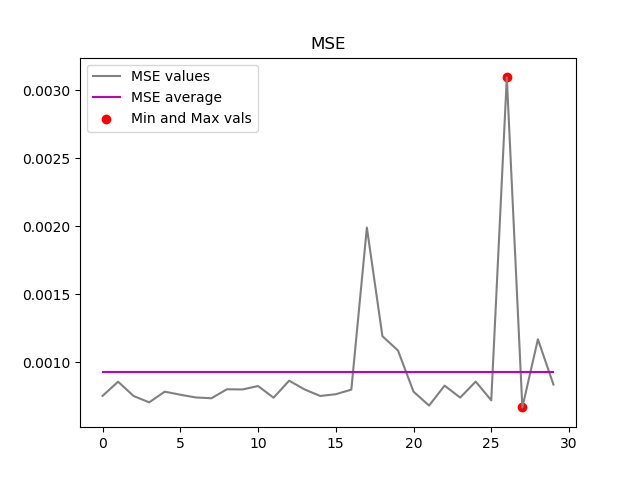

In [90]:
plot_mse(mse_list_1000_50)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 80us/step
MSE: 0.011501448228955269


<IPython.core.display.Javascript object>


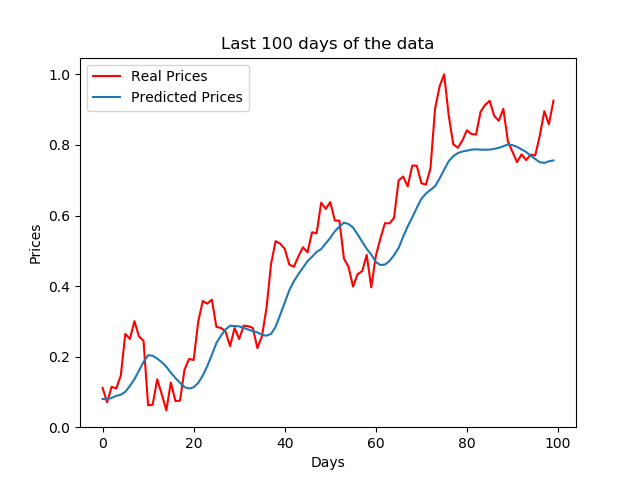

In [91]:
model4_100 = plot_predictions_and_real_prices_for_one_sample(model_1000_50, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 39us/step
MSE: 0.001505877961171791


<IPython.core.display.Javascript object>


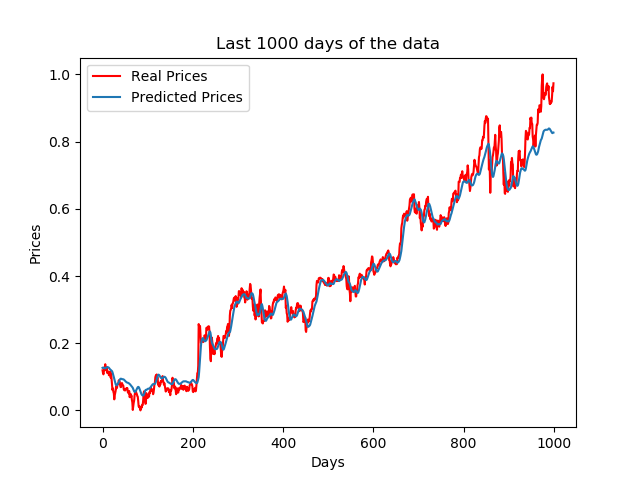

In [92]:
model4_1000 = plot_predictions_and_real_prices_for_one_sample(model_1000_50, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 47us/step
MSE: 0.0009007344453711994


<IPython.core.display.Javascript object>


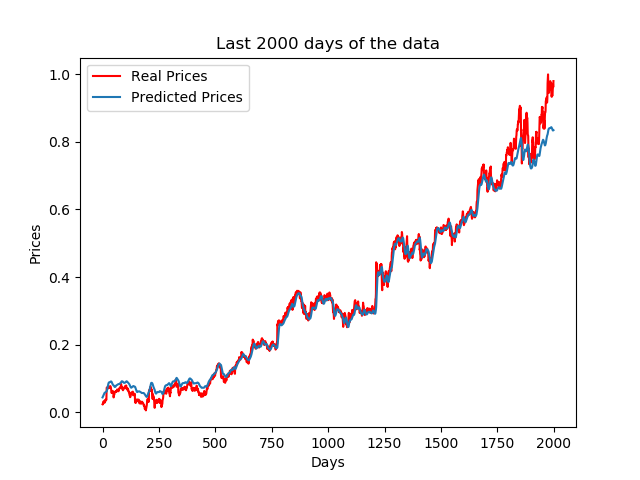

In [93]:
model4_2000 = plot_predictions_and_real_prices_for_one_sample(model_1000_50, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# MODEL 5

## Training model 5:

**(2000 input samples extracted, 70% training and 30% testing)**

In [94]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_2000_70[epoch].shape)
    print(y_train_all_2000_70[epoch].shape)
    
    # fit the model to the current data
    model_2000_70.fit(X_train_all_2000_70[epoch],
                      y_train_all_2000_70[epoch],
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(196, 54, 1)
(196, 1)
Epoch 1/50
196/196 [==============================] - 1s 6ms/step - loss: 0.2081
Epoch 2/50
196/196 [==============================] - 0s 117us/step - loss: 0.2036
Epoch 3/50
196/196 [==============================] - 0s 112us/step - loss: 0.1992
Epoch 4/50
196/196 [==============================] - 0s 142us/step - loss: 0.1947
Epoch 5/50
196/196 [==============================] - 0s 122us/step - loss: 0.1904
Epoch 6/50
196/196 [==============================] - 0s 112us/step - loss: 0.1860
Epoch 7/50
196/196 [==============================] - 0s 112us/step - loss: 0.1817
Epoch 8/50
196/196 [==============================] - 0s 107us/step - loss: 0.1774
Epoch 9/50
196/196 [==============================] - 0s 107us/step - loss: 0.1731
Epoch 10/50
196/196 [==============================] - 0s 127us/step - loss: 0.1689
Epoch 11/50
196/196 [==============================] - 0s 117us/step - loss: 0.1648
Epoch 12/50
196/196 [==============================] - 0s

168/168 [==============================] - 0s 267us/step - loss: 0.0136
Epoch 49/50
168/168 [==============================] - 0s 220us/step - loss: 0.0135
Epoch 50/50
168/168 [==============================] - 0s 220us/step - loss: 0.0134
epoch=2
(211, 33, 1)
(211, 1)
Epoch 1/50
211/211 [==============================] - 0s 66us/step - loss: 0.0093
Epoch 2/50
211/211 [==============================] - 0s 66us/step - loss: 0.0093
Epoch 3/50
211/211 [==============================] - 0s 71us/step - loss: 0.0093
Epoch 4/50
211/211 [==============================] - 0s 61us/step - loss: 0.0093
Epoch 5/50
211/211 [==============================] - 0s 66us/step - loss: 0.0092
Epoch 6/50
211/211 [==============================] - 0s 66us/step - loss: 0.0092
Epoch 7/50
211/211 [==============================] - 0s 61us/step - loss: 0.0092
Epoch 8/50
211/211 [==============================] - 0s 71us/step - loss: 0.0092
Epoch 9/50
211/211 [==============================] - 0s 85us/step - loss:

Epoch 46/50
186/186 [==============================] - 0s 155us/step - loss: 0.0092
Epoch 47/50
186/186 [==============================] - 0s 156us/step - loss: 0.0092
Epoch 48/50
186/186 [==============================] - 0s 172us/step - loss: 0.0092
Epoch 49/50
186/186 [==============================] - 0s 172us/step - loss: 0.0092
Epoch 50/50
186/186 [==============================] - 0s 155us/step - loss: 0.0092
epoch=4
(193, 59, 1)
(193, 1)
Epoch 1/50
193/193 [==============================] - 0s 140us/step - loss: 0.0092
Epoch 2/50
193/193 [==============================] - 0s 119us/step - loss: 0.0092
Epoch 3/50
193/193 [==============================] - 0s 140us/step - loss: 0.0092
Epoch 4/50
193/193 [==============================] - 0s 124us/step - loss: 0.0091
Epoch 5/50
193/193 [==============================] - 0s 134us/step - loss: 0.0091
Epoch 6/50
193/193 [==============================] - 0s 134us/step - loss: 0.0091
Epoch 7/50
193/193 [==============================] 

174/174 [==============================] - 0s 189us/step - loss: 0.0081
Epoch 44/50
174/174 [==============================] - 0s 206us/step - loss: 0.0081
Epoch 45/50
174/174 [==============================] - 0s 212us/step - loss: 0.0081
Epoch 46/50
174/174 [==============================] - 0s 189us/step - loss: 0.0081
Epoch 47/50
174/174 [==============================] - 0s 218us/step - loss: 0.0081
Epoch 48/50
174/174 [==============================] - 0s 224us/step - loss: 0.0081
Epoch 49/50
174/174 [==============================] - 0s 183us/step - loss: 0.0080
Epoch 50/50
174/174 [==============================] - 0s 189us/step - loss: 0.0080
epoch=6
(215, 27, 1)
(215, 1)
Epoch 1/50
215/215 [==============================] - 0s 65us/step - loss: 0.0075
Epoch 2/50
215/215 [==============================] - 0s 74us/step - loss: 0.0075
Epoch 3/50
215/215 [==============================] - 0s 56us/step - loss: 0.0075
Epoch 4/50
215/215 [==============================] - 0s 60us/st

Epoch 41/50
168/168 [==============================] - 0s 232us/step - loss: 0.0066
Epoch 42/50
168/168 [==============================] - 0s 255us/step - loss: 0.0066
Epoch 43/50
168/168 [==============================] - 0s 226us/step - loss: 0.0066
Epoch 44/50
168/168 [==============================] - 0s 243us/step - loss: 0.0066
Epoch 45/50
168/168 [==============================] - 0s 249us/step - loss: 0.0066
Epoch 46/50
168/168 [==============================] - 0s 237us/step - loss: 0.0066
Epoch 47/50
168/168 [==============================] - 0s 243us/step - loss: 0.0066
Epoch 48/50
168/168 [==============================] - 0s 226us/step - loss: 0.0066
Epoch 49/50
168/168 [==============================] - 0s 214us/step - loss: 0.0065
Epoch 50/50
168/168 [==============================] - 0s 208us/step - loss: 0.0065
epoch=8
(170, 92, 1)
(170, 1)
Epoch 1/50
170/170 [==============================] - 0s 229us/step - loss: 0.0068
Epoch 2/50
170/170 [===========================

173/173 [==============================] - 0s 213us/step - loss: 0.0060
Epoch 39/50
173/173 [==============================] - 0s 202us/step - loss: 0.0060
Epoch 40/50
173/173 [==============================] - 0s 202us/step - loss: 0.0060
Epoch 41/50
173/173 [==============================] - 0s 202us/step - loss: 0.0060
Epoch 42/50
173/173 [==============================] - 0s 329us/step - loss: 0.0060
Epoch 43/50
173/173 [==============================] - 0s 271us/step - loss: 0.0060
Epoch 44/50
173/173 [==============================] - 0s 306us/step - loss: 0.0060
Epoch 45/50
173/173 [==============================] - 0s 254us/step - loss: 0.0060
Epoch 46/50
173/173 [==============================] - 0s 288us/step - loss: 0.0060
Epoch 47/50
173/173 [==============================] - 0s 254us/step - loss: 0.0060
Epoch 48/50
173/173 [==============================] - 0s 623us/step - loss: 0.0060
Epoch 49/50
173/173 [==============================] - 0s 311us/step - loss: 0.0059
Epoc

Epoch 36/50
190/190 [==============================] - 0s 115us/step - loss: 0.0051
Epoch 37/50
190/190 [==============================] - 0s 131us/step - loss: 0.0051
Epoch 38/50
190/190 [==============================] - 0s 157us/step - loss: 0.0050
Epoch 39/50
190/190 [==============================] - 0s 131us/step - loss: 0.0050
Epoch 40/50
190/190 [==============================] - 0s 121us/step - loss: 0.0050
Epoch 41/50
190/190 [==============================] - 0s 126us/step - loss: 0.0050
Epoch 42/50
190/190 [==============================] - 0s 121us/step - loss: 0.0050
Epoch 43/50
190/190 [==============================] - 0s 121us/step - loss: 0.0050
Epoch 44/50
190/190 [==============================] - 0s 126us/step - loss: 0.0050
Epoch 45/50
190/190 [==============================] - 0s 136us/step - loss: 0.0050
Epoch 46/50
190/190 [==============================] - 0s 136us/step - loss: 0.0050
Epoch 47/50
190/190 [==============================] - 0s 131us/step - loss:

Epoch 34/50
214/214 [==============================] - 0s 51us/step - loss: 0.0040
Epoch 35/50
214/214 [==============================] - 0s 70us/step - loss: 0.0040
Epoch 36/50
214/214 [==============================] - 0s 51us/step - loss: 0.0040
Epoch 37/50
214/214 [==============================] - 0s 51us/step - loss: 0.0040
Epoch 38/50
214/214 [==============================] - 0s 51us/step - loss: 0.0040
Epoch 39/50
214/214 [==============================] - 0s 61us/step - loss: 0.0040
Epoch 40/50
214/214 [==============================] - 0s 51us/step - loss: 0.0040
Epoch 41/50
214/214 [==============================] - 0s 51us/step - loss: 0.0040
Epoch 42/50
214/214 [==============================] - 0s 65us/step - loss: 0.0040
Epoch 43/50
214/214 [==============================] - 0s 47us/step - loss: 0.0040
Epoch 44/50
214/214 [==============================] - 0s 51us/step - loss: 0.0040
Epoch 45/50
214/214 [==============================] - 0s 61us/step - loss: 0.0040
Epoc

Epoch 32/50
165/165 [==============================] - 0s 236us/step - loss: 0.0047
Epoch 33/50
165/165 [==============================] - 0s 218us/step - loss: 0.0046
Epoch 34/50
165/165 [==============================] - 0s 206us/step - loss: 0.0046
Epoch 35/50
165/165 [==============================] - 0s 236us/step - loss: 0.0046
Epoch 36/50
165/165 [==============================] - 0s 218us/step - loss: 0.0046
Epoch 37/50
165/165 [==============================] - 0s 236us/step - loss: 0.0046
Epoch 38/50
165/165 [==============================] - 0s 260us/step - loss: 0.0046
Epoch 39/50
165/165 [==============================] - 0s 266us/step - loss: 0.0046
Epoch 40/50
165/165 [==============================] - 0s 272us/step - loss: 0.0046
Epoch 41/50
165/165 [==============================] - 0s 326us/step - loss: 0.0046
Epoch 42/50
165/165 [==============================] - 0s 266us/step - loss: 0.0046
Epoch 43/50
165/165 [==============================] - 0s 242us/step - loss:

Epoch 30/50
227/227 [==============================] - 0s 22us/step - loss: 0.0041
Epoch 31/50
227/227 [==============================] - 0s 22us/step - loss: 0.0041
Epoch 32/50
227/227 [==============================] - 0s 26us/step - loss: 0.0041
Epoch 33/50
227/227 [==============================] - 0s 26us/step - loss: 0.0041
Epoch 34/50
227/227 [==============================] - 0s 26us/step - loss: 0.0041
Epoch 35/50
227/227 [==============================] - 0s 26us/step - loss: 0.0041
Epoch 36/50
227/227 [==============================] - 0s 26us/step - loss: 0.0041
Epoch 37/50
227/227 [==============================] - 0s 26us/step - loss: 0.0041
Epoch 38/50
227/227 [==============================] - 0s 26us/step - loss: 0.0041
Epoch 39/50
227/227 [==============================] - 0s 26us/step - loss: 0.0041
Epoch 40/50
227/227 [==============================] - 0s 31us/step - loss: 0.0041
Epoch 41/50
227/227 [==============================] - 0s 35us/step - loss: 0.0040
Epoc

Epoch 29/50
222/222 [==============================] - 0s 45us/step - loss: 0.0040
Epoch 30/50
222/222 [==============================] - 0s 40us/step - loss: 0.0040
Epoch 31/50
222/222 [==============================] - 0s 36us/step - loss: 0.0040
Epoch 32/50
222/222 [==============================] - 0s 36us/step - loss: 0.0040
Epoch 33/50
222/222 [==============================] - 0s 40us/step - loss: 0.0040
Epoch 34/50
222/222 [==============================] - 0s 40us/step - loss: 0.0040
Epoch 35/50
222/222 [==============================] - 0s 36us/step - loss: 0.0040
Epoch 36/50
222/222 [==============================] - 0s 36us/step - loss: 0.0040
Epoch 37/50
222/222 [==============================] - 0s 49us/step - loss: 0.0040
Epoch 38/50
222/222 [==============================] - 0s 36us/step - loss: 0.0040
Epoch 39/50
222/222 [==============================] - 0s 112us/step - loss: 0.0039
Epoch 40/50
222/222 [==============================] - 0s 54us/step - loss: 0.0039
Epo

Epoch 27/50
187/187 [==============================] - 0s 149us/step - loss: 0.0040
Epoch 28/50
187/187 [==============================] - 0s 155us/step - loss: 0.0040
Epoch 29/50
187/187 [==============================] - 0s 149us/step - loss: 0.0040
Epoch 30/50
187/187 [==============================] - 0s 165us/step - loss: 0.0040
Epoch 31/50
187/187 [==============================] - 0s 187us/step - loss: 0.0040
Epoch 32/50
187/187 [==============================] - 0s 160us/step - loss: 0.0040
Epoch 33/50
187/187 [==============================] - 0s 165us/step - loss: 0.0040
Epoch 34/50
187/187 [==============================] - 0s 133us/step - loss: 0.0040
Epoch 35/50
187/187 [==============================] - 0s 176us/step - loss: 0.0040
Epoch 36/50
187/187 [==============================] - 0s 187us/step - loss: 0.0040
Epoch 37/50
187/187 [==============================] - 0s 176us/step - loss: 0.0040
Epoch 38/50
187/187 [==============================] - 0s 128us/step - loss:

184/184 [==============================] - 0s 173us/step - loss: 0.0041
Epoch 25/50
184/184 [==============================] - 0s 157us/step - loss: 0.0041
Epoch 26/50
184/184 [==============================] - 0s 152us/step - loss: 0.0041
Epoch 27/50
184/184 [==============================] - 0s 163us/step - loss: 0.0041
Epoch 28/50
184/184 [==============================] - 0s 152us/step - loss: 0.0041
Epoch 29/50
184/184 [==============================] - 0s 217us/step - loss: 0.0041
Epoch 30/50
184/184 [==============================] - 0s 173us/step - loss: 0.0041
Epoch 31/50
184/184 [==============================] - 0s 173us/step - loss: 0.0041
Epoch 32/50
184/184 [==============================] - 0s 146us/step - loss: 0.0041
Epoch 33/50
184/184 [==============================] - 0s 163us/step - loss: 0.0041
Epoch 34/50
184/184 [==============================] - 0s 190us/step - loss: 0.0041
Epoch 35/50
184/184 [==============================] - 0s 168us/step - loss: 0.0041
Epoc

Epoch 22/50
186/186 [==============================] - 0s 155us/step - loss: 0.0037
Epoch 23/50
186/186 [==============================] - 0s 166us/step - loss: 0.0037
Epoch 24/50
186/186 [==============================] - 0s 150us/step - loss: 0.0037
Epoch 25/50
186/186 [==============================] - 0s 161us/step - loss: 0.0037
Epoch 26/50
186/186 [==============================] - 0s 150us/step - loss: 0.0036
Epoch 27/50
186/186 [==============================] - 0s 150us/step - loss: 0.0036
Epoch 28/50
186/186 [==============================] - 0s 155us/step - loss: 0.0036
Epoch 29/50
186/186 [==============================] - 0s 166us/step - loss: 0.0036
Epoch 30/50
186/186 [==============================] - 0s 150us/step - loss: 0.0036
Epoch 31/50
186/186 [==============================] - 0s 155us/step - loss: 0.0036
Epoch 32/50
186/186 [==============================] - 0s 145us/step - loss: 0.0036
Epoch 33/50
186/186 [==============================] - 0s 161us/step - loss:

Epoch 20/50
196/196 [==============================] - 0s 107us/step - loss: 0.0040
Epoch 21/50
196/196 [==============================] - 0s 127us/step - loss: 0.0039
Epoch 22/50
196/196 [==============================] - 0s 178us/step - loss: 0.0039
Epoch 23/50
196/196 [==============================] - 0s 122us/step - loss: 0.0038
Epoch 24/50
196/196 [==============================] - 0s 122us/step - loss: 0.0038
Epoch 25/50
196/196 [==============================] - 0s 132us/step - loss: 0.0037
Epoch 26/50
196/196 [==============================] - 0s 112us/step - loss: 0.0037
Epoch 27/50
196/196 [==============================] - 0s 117us/step - loss: 0.0037
Epoch 28/50
196/196 [==============================] - 0s 127us/step - loss: 0.0037
Epoch 29/50
196/196 [==============================] - 0s 117us/step - loss: 0.0037
Epoch 30/50
196/196 [==============================] - 0s 107us/step - loss: 0.0037
Epoch 31/50
196/196 [==============================] - 0s 132us/step - loss:

Epoch 18/50
194/194 [==============================] - 0s 129us/step - loss: 0.0031
Epoch 19/50
194/194 [==============================] - 0s 129us/step - loss: 0.0031
Epoch 20/50
194/194 [==============================] - 0s 129us/step - loss: 0.0031
Epoch 21/50
194/194 [==============================] - 0s 129us/step - loss: 0.0031
Epoch 22/50
194/194 [==============================] - 0s 129us/step - loss: 0.0031
Epoch 23/50
194/194 [==============================] - 0s 129us/step - loss: 0.0031
Epoch 24/50
194/194 [==============================] - 0s 129us/step - loss: 0.0031
Epoch 25/50
194/194 [==============================] - 0s 123us/step - loss: 0.0031
Epoch 26/50
194/194 [==============================] - 0s 129us/step - loss: 0.0031
Epoch 27/50
194/194 [==============================] - 0s 129us/step - loss: 0.0031
Epoch 28/50
194/194 [==============================] - 0s 123us/step - loss: 0.0031
Epoch 29/50
194/194 [==============================] - 0s 159us/step - loss:

## Testing model 5:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_2000_70, X_test_all_2000_70, y_test_all_2000_70)

In [96]:
mse_list_2000_70 = mse_list(model_2000_70, X_test_all_2000_70, y_test_all_2000_70, lengths)

Max mse: 0.004378720186650753 (related window: 98)
Min mse: 0.0026452375411549034 (related window: 54)
Average mse: 0.0033515268077130727


<IPython.core.display.Javascript object>


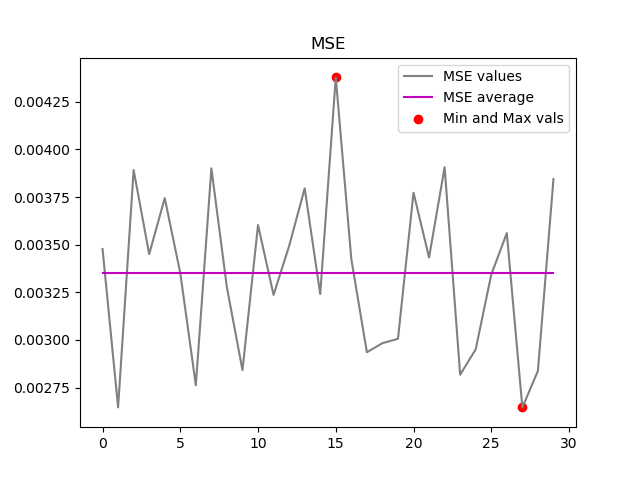

In [97]:
plot_mse(mse_list_2000_70)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 90us/step
MSE: 0.008554293662309647


<IPython.core.display.Javascript object>


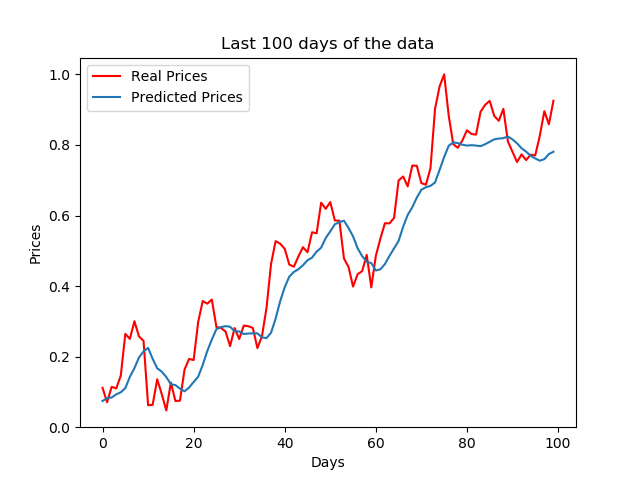

In [98]:
model5_100 = plot_predictions_and_real_prices_for_one_sample(model_2000_70, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 40us/step
MSE: 0.0010722124162130058


<IPython.core.display.Javascript object>


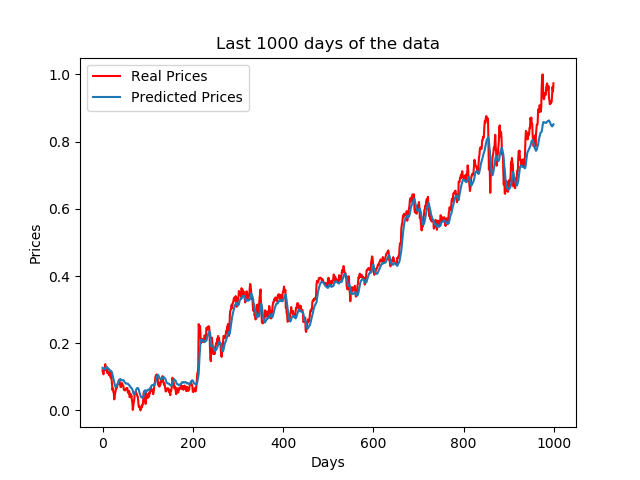

In [100]:
model5_1000 = plot_predictions_and_real_prices_for_one_sample(model_2000_70, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 43us/step
MSE: 0.0006247806235624012


<IPython.core.display.Javascript object>


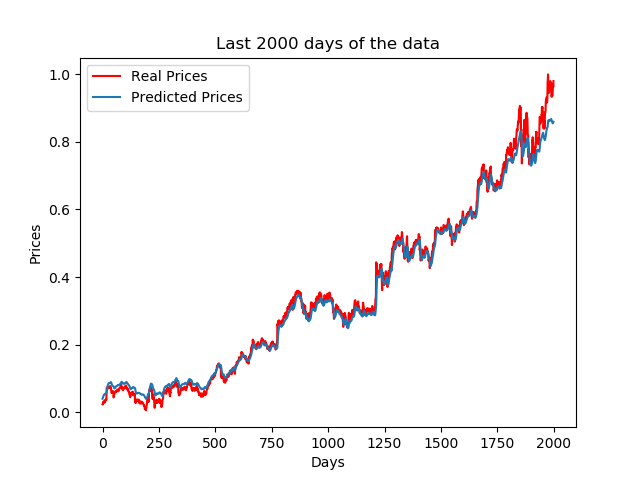

In [101]:
model5_2000 = plot_predictions_and_real_prices_for_one_sample(model_2000_70, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# MODEL 6

## Training model 6:

**(2000 input samples extracted, 50% training and 50% testing)**

In [102]:
start_time = time.time()

for epoch in range(len(lengths)):
    
    # printing out current epoch
    print(f"epoch={epoch}")
    
    # printing out the shape the current X,y data pair
    print(X_train_all_2000_50[epoch].shape)
    print(y_train_all_2000_50[epoch].shape)
    
    # fit the model to the current data
    model_2000_50.fit(X_train_all_2000_50[epoch],
                      y_train_all_2000_50[epoch],
                      epochs=EPOCHS, 
                      batch_size=BATCH_SIZE)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

epoch=0
(140, 54, 1)
(140, 1)
Epoch 1/50
140/140 [==============================] - 1s 8ms/step - loss: 0.4507
Epoch 2/50
140/140 [==============================] - 0s 185us/step - loss: 0.4441
Epoch 3/50
140/140 [==============================] - 0s 142us/step - loss: 0.4375
Epoch 4/50
140/140 [==============================] - 0s 171us/step - loss: 0.4309
Epoch 5/50
140/140 [==============================] - 0s 228us/step - loss: 0.4248
Epoch 6/50
140/140 [==============================] - 0s 142us/step - loss: 0.4183
Epoch 7/50
140/140 [==============================] - 0s 157us/step - loss: 0.4119
Epoch 8/50
140/140 [==============================] - 0s 150us/step - loss: 0.4055
Epoch 9/50
140/140 [==============================] - 0s 157us/step - loss: 0.3991
Epoch 10/50
140/140 [==============================] - 0s 157us/step - loss: 0.3928
Epoch 11/50
140/140 [==============================] - 0s 199us/step - loss: 0.3865
Epoch 12/50
140/140 [==============================] - 0s

120/120 [==============================] - 0s 299us/step - loss: 0.0538
Epoch 49/50
120/120 [==============================] - 0s 274us/step - loss: 0.0523
Epoch 50/50
120/120 [==============================] - 0s 308us/step - loss: 0.0509
epoch=2
(151, 33, 1)
(151, 1)
Epoch 1/50
151/151 [==============================] - 0s 92us/step - loss: 0.0403
Epoch 2/50
151/151 [==============================] - 0s 86us/step - loss: 0.0393
Epoch 3/50
151/151 [==============================] - 0s 139us/step - loss: 0.0384
Epoch 4/50
151/151 [==============================] - 0s 92us/step - loss: 0.0375
Epoch 5/50
151/151 [==============================] - 0s 86us/step - loss: 0.0367
Epoch 6/50
151/151 [==============================] - 0s 86us/step - loss: 0.0360
Epoch 7/50
151/151 [==============================] - 0s 125us/step - loss: 0.0352
Epoch 8/50
151/151 [==============================] - 0s 106us/step - loss: 0.0345
Epoch 9/50
151/151 [==============================] - 0s 119us/step - l

Epoch 46/50
133/133 [==============================] - 0s 217us/step - loss: 0.0242
Epoch 47/50
133/133 [==============================] - 0s 225us/step - loss: 0.0241
Epoch 48/50
133/133 [==============================] - 0s 217us/step - loss: 0.0240
Epoch 49/50
133/133 [==============================] - 0s 217us/step - loss: 0.0240
Epoch 50/50
133/133 [==============================] - 0s 210us/step - loss: 0.0239
epoch=4
(138, 59, 1)
(138, 1)
Epoch 1/50
138/138 [==============================] - 0s 195us/step - loss: 0.0222
Epoch 2/50
138/138 [==============================] - 0s 188us/step - loss: 0.0221
Epoch 3/50
138/138 [==============================] - 0s 181us/step - loss: 0.0220
Epoch 4/50
138/138 [==============================] - 0s 173us/step - loss: 0.0220
Epoch 5/50
138/138 [==============================] - 0s 173us/step - loss: 0.0219
Epoch 6/50
138/138 [==============================] - 0s 202us/step - loss: 0.0219
Epoch 7/50
138/138 [==============================] 

124/124 [==============================] - 0s 257us/step - loss: 0.0163
Epoch 44/50
124/124 [==============================] - 0s 249us/step - loss: 0.0162
Epoch 45/50
124/124 [==============================] - 0s 282us/step - loss: 0.0162
Epoch 46/50
124/124 [==============================] - 0s 290us/step - loss: 0.0161
Epoch 47/50
124/124 [==============================] - 0s 290us/step - loss: 0.0161
Epoch 48/50
124/124 [==============================] - 0s 257us/step - loss: 0.0160
Epoch 49/50
124/124 [==============================] - 0s 265us/step - loss: 0.0160
Epoch 50/50
124/124 [==============================] - 0s 290us/step - loss: 0.0159
epoch=6
(154, 27, 1)
(154, 1)
Epoch 1/50
154/154 [==============================] - 0s 84us/step - loss: 0.0158
Epoch 2/50
154/154 [==============================] - 0s 65us/step - loss: 0.0158
Epoch 3/50
154/154 [==============================] - 0s 123us/step - loss: 0.0157
Epoch 4/50
154/154 [==============================] - 0s 91us/s

Epoch 41/50
120/120 [==============================] - 0s 349us/step - loss: 0.0133
Epoch 42/50
120/120 [==============================] - 0s 332us/step - loss: 0.0133
Epoch 43/50
120/120 [==============================] - 0s 349us/step - loss: 0.0133
Epoch 44/50
120/120 [==============================] - 0s 274us/step - loss: 0.0132
Epoch 45/50
120/120 [==============================] - 0s 274us/step - loss: 0.0132
Epoch 46/50
120/120 [==============================] - 0s 274us/step - loss: 0.0132
Epoch 47/50
120/120 [==============================] - 0s 349us/step - loss: 0.0132
Epoch 48/50
120/120 [==============================] - 0s 440us/step - loss: 0.0131
Epoch 49/50
120/120 [==============================] - 0s 333us/step - loss: 0.0131
Epoch 50/50
120/120 [==============================] - 0s 291us/step - loss: 0.0131
epoch=8
(121, 92, 1)
(121, 1)
Epoch 1/50
121/121 [==============================] - 0s 354us/step - loss: 0.0132
Epoch 2/50
121/121 [===========================

124/124 [==============================] - 0s 274us/step - loss: 0.0113
Epoch 39/50
124/124 [==============================] - 0s 322us/step - loss: 0.0113
Epoch 40/50
124/124 [==============================] - 0s 249us/step - loss: 0.0113
Epoch 41/50
124/124 [==============================] - 0s 290us/step - loss: 0.0113
Epoch 42/50
124/124 [==============================] - 0s 282us/step - loss: 0.0112
Epoch 43/50
124/124 [==============================] - 0s 257us/step - loss: 0.0112
Epoch 44/50
124/124 [==============================] - 0s 273us/step - loss: 0.0112
Epoch 45/50
124/124 [==============================] - 0s 314us/step - loss: 0.0112
Epoch 46/50
124/124 [==============================] - 0s 298us/step - loss: 0.0112
Epoch 47/50
124/124 [==============================] - 0s 282us/step - loss: 0.0112
Epoch 48/50
124/124 [==============================] - 0s 257us/step - loss: 0.0111
Epoch 49/50
124/124 [==============================] - 0s 338us/step - loss: 0.0111
Epoc

Epoch 36/50
136/136 [==============================] - 0s 191us/step - loss: 0.0091
Epoch 37/50
136/136 [==============================] - 0s 176us/step - loss: 0.0091
Epoch 38/50
136/136 [==============================] - 0s 205us/step - loss: 0.0090
Epoch 39/50
136/136 [==============================] - 0s 198us/step - loss: 0.0090
Epoch 40/50
136/136 [==============================] - 0s 191us/step - loss: 0.0090
Epoch 41/50
136/136 [==============================] - 0s 176us/step - loss: 0.0090
Epoch 42/50
136/136 [==============================] - 0s 198us/step - loss: 0.0090
Epoch 43/50
136/136 [==============================] - 0s 198us/step - loss: 0.0090
Epoch 44/50
136/136 [==============================] - 0s 183us/step - loss: 0.0090
Epoch 45/50
136/136 [==============================] - 0s 169us/step - loss: 0.0090
Epoch 46/50
136/136 [==============================] - 0s 191us/step - loss: 0.0090
Epoch 47/50
136/136 [==============================] - 0s 198us/step - loss:

Epoch 34/50
153/153 [==============================] - 0s 78us/step - loss: 0.0071
Epoch 35/50
153/153 [==============================] - 0s 78us/step - loss: 0.0071
Epoch 36/50
153/153 [==============================] - 0s 85us/step - loss: 0.0070
Epoch 37/50
153/153 [==============================] - 0s 98us/step - loss: 0.0070
Epoch 38/50
153/153 [==============================] - 0s 117us/step - loss: 0.0070
Epoch 39/50
153/153 [==============================] - 0s 91us/step - loss: 0.0070
Epoch 40/50
153/153 [==============================] - 0s 78us/step - loss: 0.0070
Epoch 41/50
153/153 [==============================] - 0s 85us/step - loss: 0.0070
Epoch 42/50
153/153 [==============================] - 0s 91us/step - loss: 0.0070
Epoch 43/50
153/153 [==============================] - 0s 85us/step - loss: 0.0070
Epoch 44/50
153/153 [==============================] - 0s 91us/step - loss: 0.0070
Epoch 45/50
153/153 [==============================] - 0s 78us/step - loss: 0.0070
Epo

Epoch 32/50
118/118 [==============================] - 0s 296us/step - loss: 0.0086
Epoch 33/50
118/118 [==============================] - 0s 313us/step - loss: 0.0086
Epoch 34/50
118/118 [==============================] - 0s 330us/step - loss: 0.0086
Epoch 35/50
118/118 [==============================] - 0s 304us/step - loss: 0.0086
Epoch 36/50
118/118 [==============================] - 0s 330us/step - loss: 0.0086
Epoch 37/50
118/118 [==============================] - 0s 347us/step - loss: 0.0086
Epoch 38/50
118/118 [==============================] - 0s 355us/step - loss: 0.0086
Epoch 39/50
118/118 [==============================] - 0s 321us/step - loss: 0.0086
Epoch 40/50
118/118 [==============================] - 0s 380us/step - loss: 0.0085
Epoch 41/50
118/118 [==============================] - 0s 313us/step - loss: 0.0085
Epoch 42/50
118/118 [==============================] - 0s 439us/step - loss: 0.0085
Epoch 43/50
118/118 [==============================] - 0s 321us/step - loss:

Epoch 30/50
162/162 [==============================] - 0s 43us/step - loss: 0.0061
Epoch 31/50
162/162 [==============================] - 0s 37us/step - loss: 0.0061
Epoch 32/50
162/162 [==============================] - 0s 49us/step - loss: 0.0061
Epoch 33/50
162/162 [==============================] - 0s 37us/step - loss: 0.0061
Epoch 34/50
162/162 [==============================] - 0s 49us/step - loss: 0.0061
Epoch 35/50
162/162 [==============================] - 0s 37us/step - loss: 0.0061
Epoch 36/50
162/162 [==============================] - 0s 43us/step - loss: 0.0061
Epoch 37/50
162/162 [==============================] - 0s 37us/step - loss: 0.0061
Epoch 38/50
162/162 [==============================] - 0s 37us/step - loss: 0.0061
Epoch 39/50
162/162 [==============================] - 0s 37us/step - loss: 0.0061
Epoch 40/50
162/162 [==============================] - 0s 37us/step - loss: 0.0061
Epoch 41/50
162/162 [==============================] - 0s 68us/step - loss: 0.0060
Epoc

Epoch 29/50
159/159 [==============================] - 0s 50us/step - loss: 0.0058
Epoch 30/50
159/159 [==============================] - 0s 56us/step - loss: 0.0058
Epoch 31/50
159/159 [==============================] - 0s 69us/step - loss: 0.0058
Epoch 32/50
159/159 [==============================] - 0s 88us/step - loss: 0.0058
Epoch 33/50
159/159 [==============================] - 0s 69us/step - loss: 0.0058
Epoch 34/50
159/159 [==============================] - 0s 50us/step - loss: 0.0058
Epoch 35/50
159/159 [==============================] - 0s 56us/step - loss: 0.0058
Epoch 36/50
159/159 [==============================] - 0s 56us/step - loss: 0.0058
Epoch 37/50
159/159 [==============================] - 0s 50us/step - loss: 0.0058
Epoch 38/50
159/159 [==============================] - 0s 63us/step - loss: 0.0058
Epoch 39/50
159/159 [==============================] - 0s 56us/step - loss: 0.0058
Epoch 40/50
159/159 [==============================] - 0s 50us/step - loss: 0.0058
Epoc

Epoch 27/50
134/134 [==============================] - 0s 216us/step - loss: 0.0061
Epoch 28/50
134/134 [==============================] - 0s 223us/step - loss: 0.0061
Epoch 29/50
134/134 [==============================] - 0s 186us/step - loss: 0.0060
Epoch 30/50
134/134 [==============================] - 0s 216us/step - loss: 0.0060
Epoch 31/50
134/134 [==============================] - 0s 246us/step - loss: 0.0060
Epoch 32/50
134/134 [==============================] - 0s 194us/step - loss: 0.0060
Epoch 33/50
134/134 [==============================] - 0s 246us/step - loss: 0.0060
Epoch 34/50
134/134 [==============================] - 0s 208us/step - loss: 0.0060
Epoch 35/50
134/134 [==============================] - 0s 231us/step - loss: 0.0060
Epoch 36/50
134/134 [==============================] - 0s 201us/step - loss: 0.0060
Epoch 37/50
134/134 [==============================] - 0s 216us/step - loss: 0.0060
Epoch 38/50
134/134 [==============================] - 0s 223us/step - loss:

131/131 [==============================] - 0s 213us/step - loss: 0.0067
Epoch 25/50
131/131 [==============================] - 0s 213us/step - loss: 0.0067
Epoch 26/50
131/131 [==============================] - 0s 221us/step - loss: 0.0067
Epoch 27/50
131/131 [==============================] - 0s 213us/step - loss: 0.0067
Epoch 28/50
131/131 [==============================] - 0s 221us/step - loss: 0.0067
Epoch 29/50
131/131 [==============================] - 0s 236us/step - loss: 0.0067
Epoch 30/50
131/131 [==============================] - 0s 244us/step - loss: 0.0067
Epoch 31/50
131/131 [==============================] - 0s 213us/step - loss: 0.0067
Epoch 32/50
131/131 [==============================] - 0s 236us/step - loss: 0.0067
Epoch 33/50
131/131 [==============================] - 0s 244us/step - loss: 0.0067
Epoch 34/50
131/131 [==============================] - 0s 236us/step - loss: 0.0067
Epoch 35/50
131/131 [==============================] - 0s 228us/step - loss: 0.0067
Epoc

Epoch 22/50
133/133 [==============================] - 0s 187us/step - loss: 0.0065
Epoch 23/50
133/133 [==============================] - 0s 225us/step - loss: 0.0065
Epoch 24/50
133/133 [==============================] - 0s 195us/step - loss: 0.0065
Epoch 25/50
133/133 [==============================] - 0s 195us/step - loss: 0.0065
Epoch 26/50
133/133 [==============================] - 0s 225us/step - loss: 0.0065
Epoch 27/50
133/133 [==============================] - 0s 255us/step - loss: 0.0065
Epoch 28/50
133/133 [==============================] - 0s 225us/step - loss: 0.0065
Epoch 29/50
133/133 [==============================] - 0s 247us/step - loss: 0.0065
Epoch 30/50
133/133 [==============================] - 0s 202us/step - loss: 0.0064
Epoch 31/50
133/133 [==============================] - 0s 210us/step - loss: 0.0064
Epoch 32/50
133/133 [==============================] - 0s 202us/step - loss: 0.0064
Epoch 33/50
133/133 [==============================] - 0s 195us/step - loss:

Epoch 20/50
140/140 [==============================] - 0s 164us/step - loss: 0.0046
Epoch 21/50
140/140 [==============================] - 0s 214us/step - loss: 0.0046
Epoch 22/50
140/140 [==============================] - 0s 150us/step - loss: 0.0046
Epoch 23/50
140/140 [==============================] - 0s 150us/step - loss: 0.0046
Epoch 24/50
140/140 [==============================] - 0s 164us/step - loss: 0.0046
Epoch 25/50
140/140 [==============================] - 0s 157us/step - loss: 0.0046
Epoch 26/50
140/140 [==============================] - 0s 171us/step - loss: 0.0046
Epoch 27/50
140/140 [==============================] - 0s 171us/step - loss: 0.0046
Epoch 28/50
140/140 [==============================] - 0s 214us/step - loss: 0.0046
Epoch 29/50
140/140 [==============================] - 0s 164us/step - loss: 0.0046
Epoch 30/50
140/140 [==============================] - 0s 135us/step - loss: 0.0046
Epoch 31/50
140/140 [==============================] - 0s 192us/step - loss:

Epoch 18/50
139/139 [==============================] - 0s 172us/step - loss: 0.0056
Epoch 19/50
139/139 [==============================] - 0s 208us/step - loss: 0.0056
Epoch 20/50
139/139 [==============================] - 0s 172us/step - loss: 0.0056
Epoch 21/50
139/139 [==============================] - 0s 208us/step - loss: 0.0056
Epoch 22/50
139/139 [==============================] - 0s 151us/step - loss: 0.0056
Epoch 23/50
139/139 [==============================] - 0s 172us/step - loss: 0.0056
Epoch 24/50
139/139 [==============================] - 0s 172us/step - loss: 0.0056
Epoch 25/50
139/139 [==============================] - 0s 151us/step - loss: 0.0056
Epoch 26/50
139/139 [==============================] - 0s 179us/step - loss: 0.0056
Epoch 27/50
139/139 [==============================] - 0s 151us/step - loss: 0.0056
Epoch 28/50
139/139 [==============================] - 0s 165us/step - loss: 0.0056
Epoch 29/50
139/139 [==============================] - 0s 172us/step - loss:

## Testing model 6:

### (on testing data)

In [ ]:
# Running This cell will result in a lot of figures, which will make the notebook size very large
# plot_predictions_and_real_prices_for_multiple_samples(model_2000_50, X_test_all_2000_50, y_test_all_2000_50)

In [104]:
mse_list_2000_50 = mse_list(model_2000_50, X_test_all_2000_50, y_test_all_2000_50, lengths)

Max mse: 0.006579525596664652 (related window: 13)
Min mse: 0.004376714222077558 (related window: 68)
Average mse: 0.005185134454096252


<IPython.core.display.Javascript object>


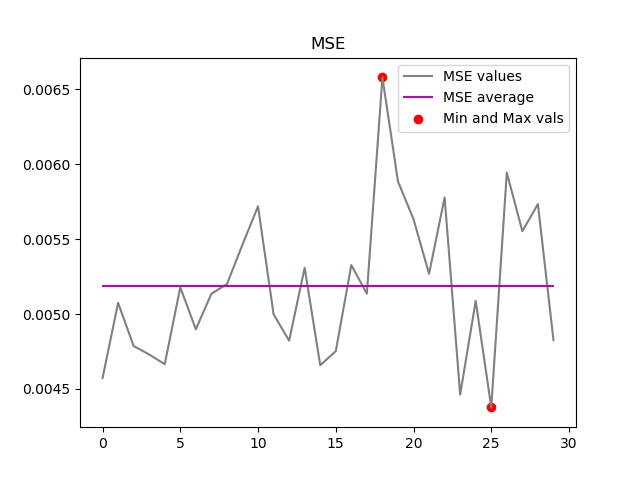

In [105]:
plot_mse(mse_list_2000_50)

### (on the last 100 days of the data)

100/100 [==============================] - 0s 80us/step
MSE: 0.011616091877222061


<IPython.core.display.Javascript object>


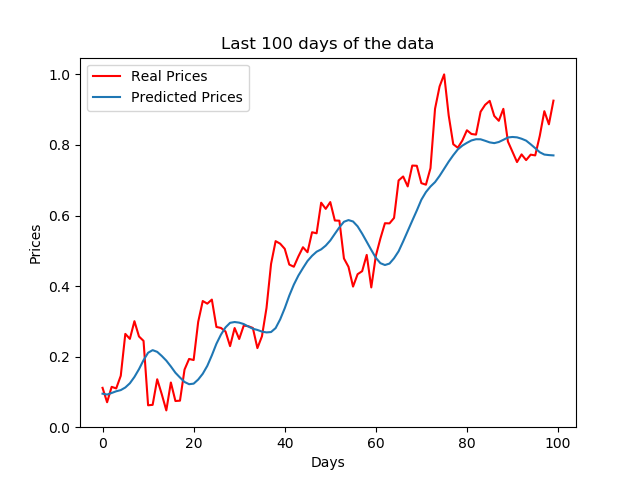

In [106]:
model6_100 = plot_predictions_and_real_prices_for_one_sample(model_2000_50, X_test_sample_100, y_test_sample_100, 
                                                             title='Last 100 days of the data')

### (on the last 1000 days of the data)

1000/1000 [==============================] - 0s 59us/step
MSE: 0.0014031061867717653


<IPython.core.display.Javascript object>


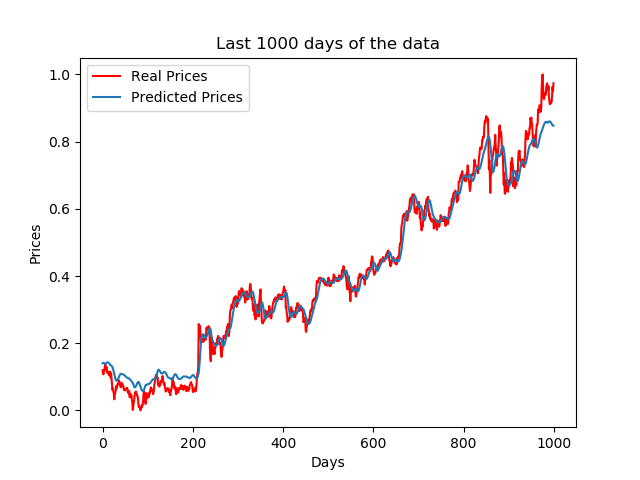

In [107]:
model6_1000 = plot_predictions_and_real_prices_for_one_sample(model_2000_50, X_test_sample_1000, y_test_sample_1000, 
                                                             title='Last 1000 days of the data')

### (on the last 2000 days of the data)

2000/2000 [==============================] - 0s 48us/step
MSE: 0.0008722508067730814


<IPython.core.display.Javascript object>


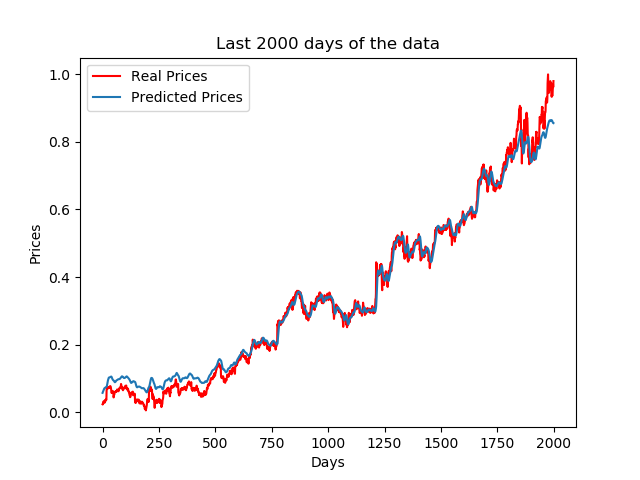

In [108]:
model6_2000 = plot_predictions_and_real_prices_for_one_sample(model_2000_50, X_test_sample_2000, y_test_sample_2000, 
                                                             title='Last 2000 days of the data')

# Comparing Models

## Visually:

Prepare the lists that are needed as parameters for the functions that will be used.

In [109]:
all_test_mse_lists = [mse_list_100_70, # list of MSE values for the Model 1 on Testing data
                     mse_list_100_50, # list of MSE values for the Model 2 on Testing data
                     mse_list_1000_70, # list of MSE values for the Model 3 on Testing data
                     mse_list_1000_50, # list of MSE values for the Model 4 on Testing data
                     mse_list_2000_70, # list of MSE values for the Model 5 on Testing data
                     mse_list_2000_70 # list of MSE values for the Model 6 on Testing data
                    ]
# MSE for each model on the 100 saved unseen input sample
all_100_mse_list = [model1_100, model2_100, model3_100, model4_100, model5_100, model6_100]
# MSE for each model on the 1000 saved unseen input sample
all_1000_mse_list = [model1_1000, model2_1000, model3_1000, model4_1000, model5_1000, model6_1000]
# MSE for each model on the 2000 saved unseen input sample
all_2000_mse_list = [model1_2000, model2_2000, model3_2000, model4_2000, model5_2000, model6_2000]

In [110]:
x_ticks_labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']

## Plot MSE for models on testing data

Concretely, three barplots will be plotted showing the minimum, maximum and average MSE values, respectively, on the testing data.

<IPython.core.display.Javascript object>


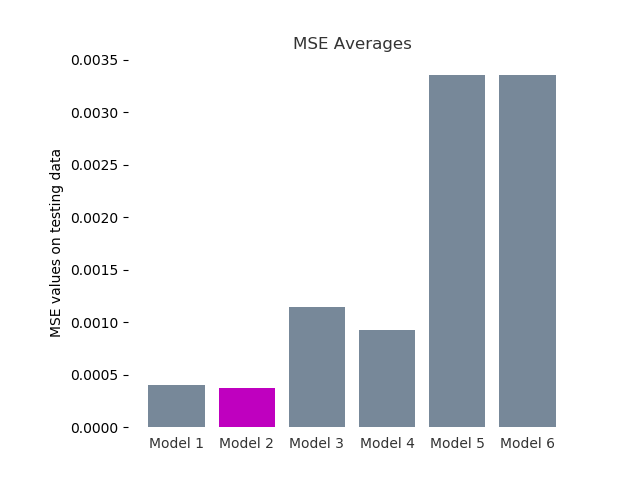

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


<IPython.core.display.Javascript object>


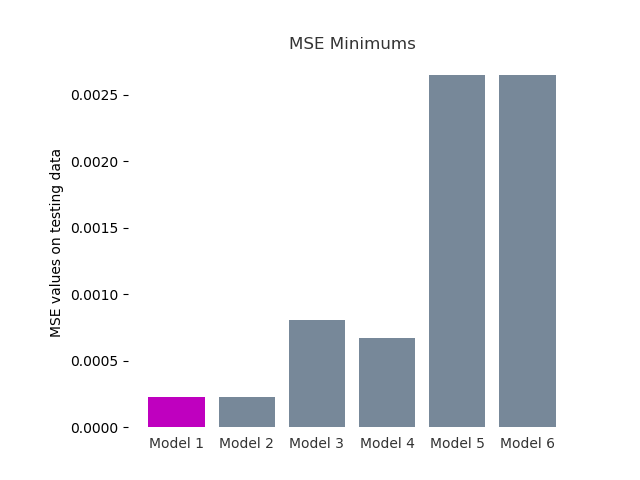

<IPython.core.display.Javascript object>


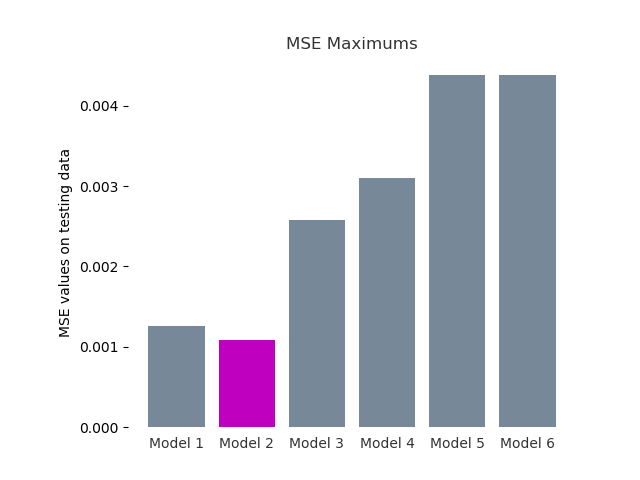

In [111]:
visualize_models_on_testing_data(all_test_mse_lists)

## Plot MSE for models on last 100 days

<IPython.core.display.Javascript object>


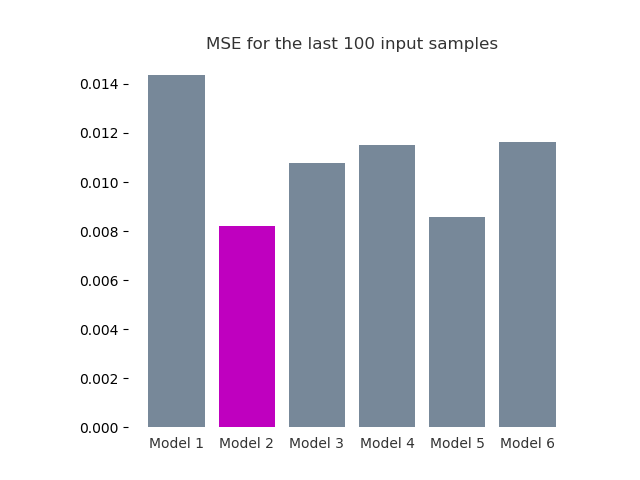

In [112]:
barplot(all_100_mse_list, x_ticks_labels, title='MSE for the last 100 input samples', 
        remove_ticks=True, remove_frame=True)

## Plot MSE for models on last 1000 days

<IPython.core.display.Javascript object>


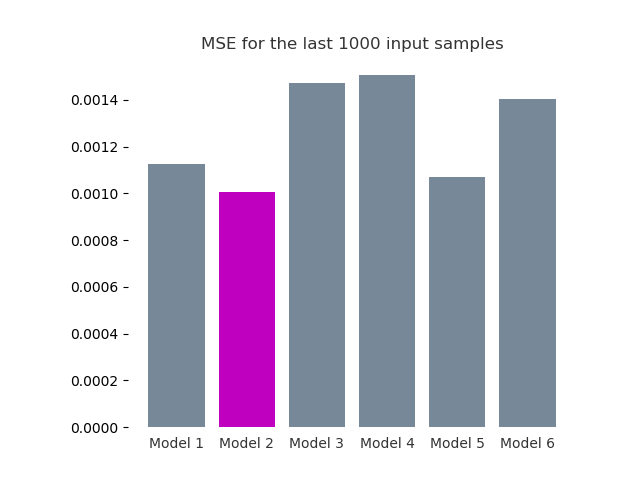

In [113]:
barplot(all_1000_mse_list, x_ticks_labels, title='MSE for the last 1000 input samples', 
        remove_ticks=True, remove_frame=True)

## Plot MSE for models on last 2000 days

<IPython.core.display.Javascript object>


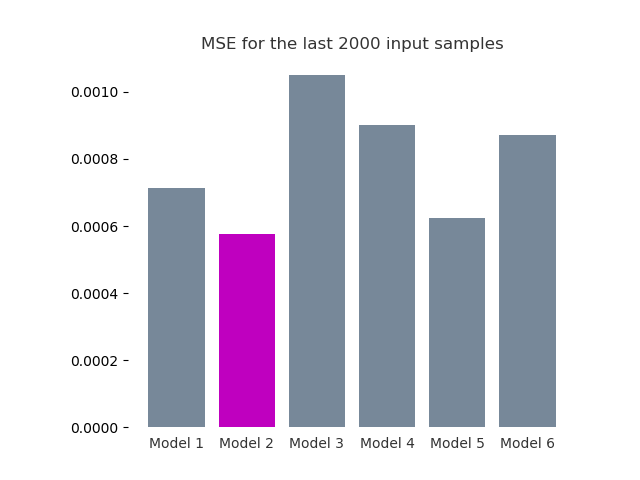

In [114]:
barplot(all_2000_mse_list, x_ticks_labels, title='MSE for the last 2000 input samples', 
        remove_ticks=True, remove_frame=True)

# Tabularly

Prepare the lists that are needed as parameters for the functions that will be used.

In [115]:
models = [model_100_70, model_100_50, model_1000_70, model_1000_50, model_2000_70, model_2000_50]
# Each sample for the last (100, 1000, and 2000) days:
X_test_lists = [X_test_sample_100, X_test_sample_1000, X_test_sample_2000]
y_test_lists = [y_test_sample_100, y_test_sample_1000, y_test_sample_2000]

In [116]:
models_names =  ['model_100_70','model_100_50','model_1000_70','model_1000_50','model_2000_70','model_2000_50']

In [117]:
mse_on_test_data = [ mse_list_100_70, mse_list_100_50, mse_list_1000_70, mse_list_1000_50, 
                    mse_list_2000_70, mse_list_2000_50]

## MSE on testing data

Evaluate each model's performance on each (X,y) pair of Numpy arrays (each generated with a different length of sequences) in the testing data.

In [118]:
mse_on_test_df = mse_on_testing_data_df(mse_on_test_data, models_names, lengths)
mse_on_test_df

,model_100_70,model_100_50,model_1000_70,model_1000_50,model_2000_70,model_2000_50
54,0.000276,0.000261,0.000848,0.000753,0.003477,0.004572
94,0.000294,0.000275,0.000939,0.000857,0.002646,0.005075
33,0.000276,0.000247,0.000893,0.000751,0.003892,0.004787
68,0.000294,0.000272,0.000987,0.000705,0.003450,0.004730
59,0.000315,0.000272,0.000822,0.000784,0.003745,0.004666
86,0.000278,0.000281,0.001057,0.000761,0.003351,0.005178
27,0.000344,0.000315,0.001044,0.000741,0.002762,0.004898
94,0.000253,0.000230,0.000964,0.000735,0.003901,0.005136
92,0.000264,0.000257,0.000987,0.000801,0.003275,0.005200
87,0.000322,0.000257,0.001018,0.000800,0.002841,0.005463


## MSE on the last samples

Evaluate each model's performance on each of the last 100, 1000 and 2000 days (totally unseen data).

In [119]:
mse_last_samples_df = mse_on_samples_df(models, X_test_lists, y_test_lists, 
                                        ['last_100_days','last_1000_days','last_2000_days'], models_names)
mse_last_samples_df

,model,last_100_days,last_1000_days,last_2000_days
0,model_100_70,0.007907,0.001127,0.000713
1,model_100_50,0.008198,0.001007,0.000575
2,model_1000_70,0.010784,0.001474,0.001050
3,model_1000_50,0.011501,0.001506,0.000901
4,model_2000_70,0.008554,0.001072,0.000625
5,model_2000_50,0.011616,0.001403,0.000872


# Saving the models

In [120]:
main_path = "E:\\Senior-Year  graduation project\\Latest results and models - 26-May-2019\\"

In [121]:
path_100_70 = "Google models\\model_100_70.h5"
path_100_50 = "Google models\\model_100_50.h5"

path_1000_70 = "Google models\\model_1000_70.h5"
path_1000_50 = "Google models\\model_1000_50.h5"

path_2000_70 = "Google models\\model_2000_70.h5"
path_2000_50 = "Google models\\model_2000_50.h5"

In [122]:
model_100_70.save(main_path+path_100_70)
model_100_50.save(main_path+path_100_50)

model_1000_70.save(main_path+path_1000_70)
model_1000_50.save(main_path+path_1000_50)

model_2000_70.save(main_path+path_2000_70)
model_2000_50.save(main_path+path_2000_50)

## Saving the resulted tables

In [123]:
mse_on_test_df.to_csv(main_path+"Google MSE tables\\mse_on_testing_data.csv")
mse_last_samples_df.to_csv(main_path+"Google MSE tables\\mse_on_last_samples.csv")